# Section 4: Advanced Models

#### PyData London 2025 - Bayesian Time Series Analysis with PyMC

---

In this section, we explore advanced techniques for modeling time series data using **generative models** and **Gaussian processes**. These approaches allow us to build flexible, interpretable models that can capture complex patterns in temporal data while quantifying our uncertainty about predictions.

A **generative model** is a probabilistic approach where we specify how we believe the data was generated. Rather than simply fitting a curve to observations, we build a model that describes the underlying processes that produce the observed patterns. This philosophy aligns perfectly with Bayesian inference, where we combine our prior knowledge about these processes with observed data to update our beliefs.

In [1]:
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import seaborn as sns
import scipy as sp
from scipy import signal

import pymc as pm
import pytensor
import pytensor.tensor as pt
import arviz as az

os.environ['PYTENSOR_FLAGS'] = 'mode=FAST_COMPILE,device=cpu,floatX=float64'
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=SyntaxWarning)

az.style.use("arviz-darkgrid")
RNG = np.random.default_rng(RANDOM_SEED:=42)


# A Generative Births Model

Let's demonstrate the power of generative modeling by analyzing daily birth counts from the United States. This classic dataset, featured in Gelman et al.'s *Bayesian Data Analysis*, provides an excellent case study for time series modeling because it exhibits multiple overlapping patterns that affect birth rates.

<img src="images/bda_cover.png" alt="BDA" width="50%">

When we think about what influences the number of births on any given day, several factors come to mind. Some births are scheduled (induced labor or caesarean sections), which means fewer births occur on weekends and holidays when hospitals prefer not to schedule elective procedures. There are also natural biological and social patterns that create seasonal variations—for instance, conception rates may vary throughout the year due to social factors, leading to birth rate peaks roughly nine months later.

Our **generative approach** means we'll explicitly model each of these effects as separate components that combine to produce the observed birth counts. Rather than using a black-box method that might capture these patterns implicitly, we'll build our understanding of the phenomenon directly into the model structure. This approach offers several advantages:

1. **Interpretability**: Each component has a clear real-world interpretation
2. **Flexibility**: We can add or modify components based on domain knowledge  
3. **Uncertainty quantification**: We get credible intervals for each effect
4. **Extrapolation**: The model can make principled predictions beyond the observed data

The key patterns we'll model include:
- **Day-of-week effects**: The systematic reduction in births on weekends due to scheduling practices
- **Holiday effects**: Further reductions on major holidays when medical staff prefer to be off
- **Annual seasonality**: Biological and social factors creating within-year patterns
- **Long-term trends**: Changes in birth rates due to demographic and social shifts
- **Complex periodicities**: Multi-year cycles reflecting economic and societal changes

## Load and Prepare Data

In [2]:
births_df = pd.read_csv('../data/births.csv')

births_df = births_df.dropna(subset=['day'])
births_df = births_df[births_df['day'] <= 31]
births_df = births_df[births_df['day'] >= 1]

births_df['year'] = births_df['year'].astype(int)
births_df['month'] = births_df['month'].astype(int)
births_df['day'] = births_df['day'].astype(int)

births_df['date_str'] = (births_df['year'].astype(str) + '-' + 
                         births_df['month'].astype(str).str.zfill(2) + '-' + 
                         births_df['day'].astype(str).str.zfill(2))
births_df['date'] = pd.to_datetime(births_df['date_str'], format='%Y-%m-%d', errors='coerce')

births_df = births_df.dropna(subset=['date'])

daily_births = births_df.groupby('date')['births'].sum().reset_index()
daily_births = daily_births.sort_values('date')

y = daily_births['births'].values
y_mean = y.mean()
y_std = y.std()
y_scaled = (y - y_mean) / y_std

t_days = (daily_births['date'] - daily_births['date'].min()).dt.days.values
t = t_days / t_days.max()  # Scale to [0, 1]
years_elapsed = t_days / 365.25

print(f"Total days: {len(y)}")

Total days: 7305


## Exploring the Data

Before building our model, let's examine the birth data to understand its structure and identify the patterns we need to capture. Time series exploration is a crucial first step—it helps us make informed modeling decisions and validates our domain knowledge about the phenomenon.

The plot below shows twenty years of daily birth counts in the United States. Even at this scale, several patterns are immediately apparent: the data exhibits considerable day-to-day variation, there appear to be seasonal oscillations, and the overall level seems to change over time. Let's investigate these patterns more systematically.

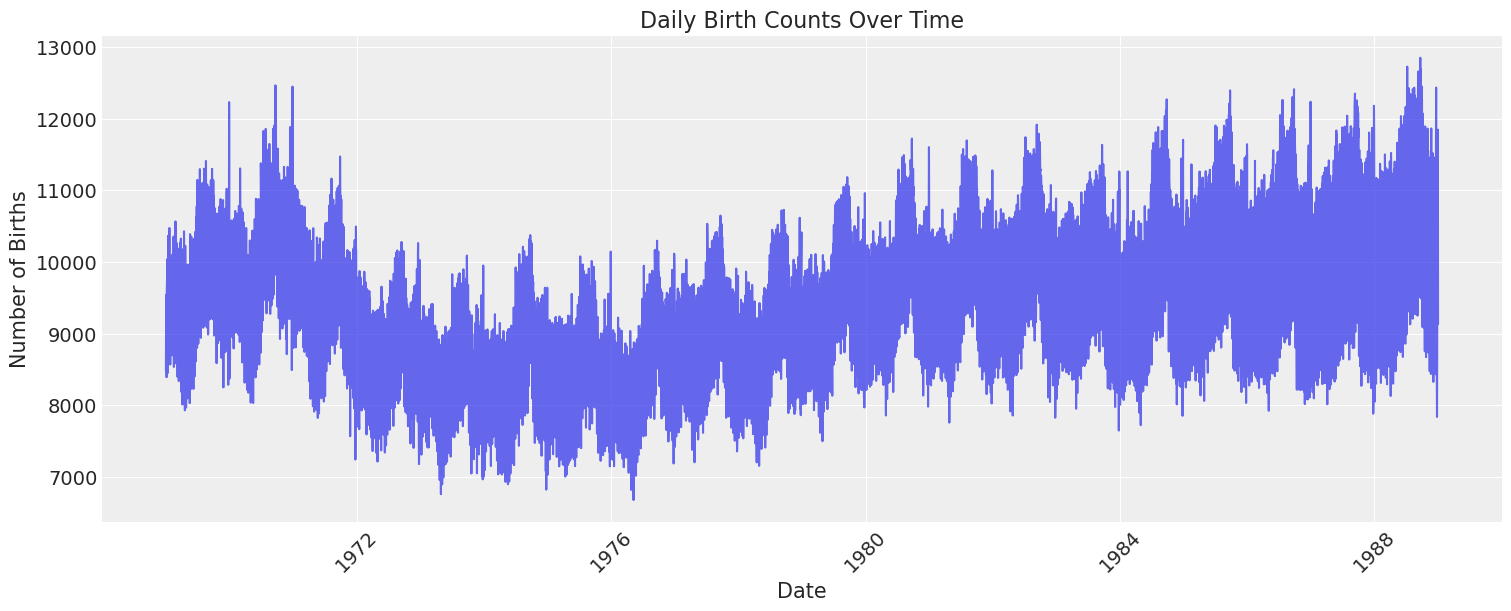

In [3]:
plt.figure(figsize=(15, 6))
plt.plot(daily_births['date'], y, alpha=0.7)
plt.title('Daily Birth Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.xticks(rotation=45);

This day-of-week pattern immediately reveals the influence of **medical scheduling practices** on birth timing. The relatively flat pattern from Monday through Friday reflects the standard work week, with Tuesday showing a slight peak. The dramatic drop on weekends—particularly Sunday—demonstrates that when given a choice, medical professionals and parents prefer to schedule births during regular working hours. This pattern has important implications for our modeling approach: we'll need to explicitly account for these day-of-week effects to avoid biasing our estimates of other patterns.

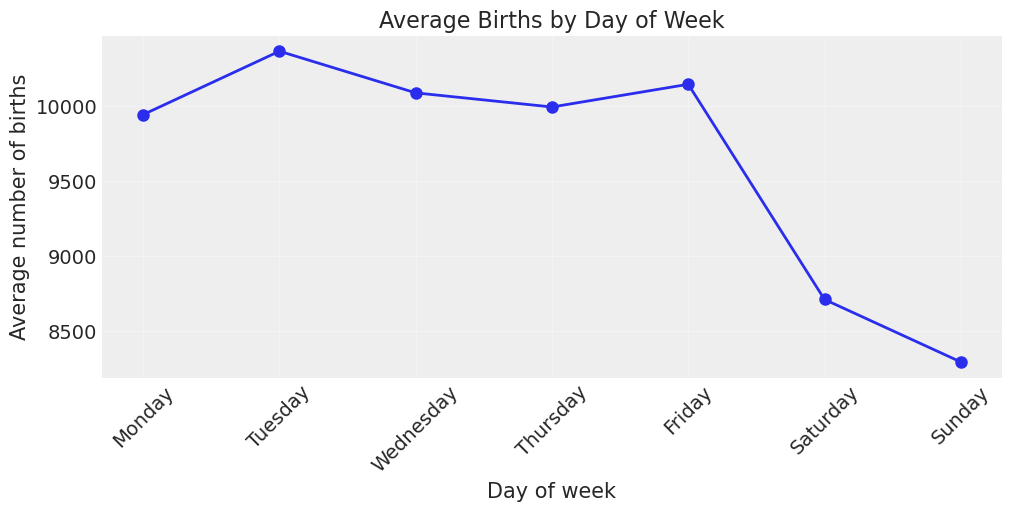

In [4]:
daily_births['day_of_week'] = daily_births['date'].dt.day_name()
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_by_dow = daily_births.groupby('day_of_week')['births'].mean().reindex(dow_order)

plt.figure(figsize=(10, 5))
plt.plot(dow_order, avg_by_dow.values, marker='o', linewidth=2, markersize=8)
plt.title('Average Births by Day of Week')
plt.ylabel('Average number of births')
plt.xlabel('Day of week')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45);

## Linear Trend Model

Following the principle of starting simple and adding complexity, we begin with the most basic time series model—a **linear trend**. This model assumes that births change at a constant rate over time, which we can express mathematically as:

$$y_t = \alpha + \beta \cdot t + \epsilon_t$$

where $y_t$ represents the (scaled) number of births at time $t$, $\alpha$ is the **intercept** (baseline birth rate), $\beta$ is the **slope** (rate of change), and $\epsilon_t$ represents random noise.

In Bayesian modeling, we must specify **prior distributions** for our parameters. These priors encode our beliefs about plausible parameter values before seeing the data. For this initial model, we use **weakly informative priors**:

- $\alpha \sim \text{Normal}(0, 1)$: Since we've standardized the data, we expect the intercept to be near zero
- $\beta \sim \text{Normal}(0, 1)$: We don't expect extreme trends in the standardized data
- $\sigma \sim \text{Half-Normal}(1)$: The noise scale should be positive and moderate

The beauty of Bayesian modeling is that we can perform a **prior predictive check**—simulating data from our model using only the priors. This helps us verify that our prior choices generate reasonable data patterns before we fit the model to actual observations.

In [5]:
with pm.Model(check_bounds=False) as linear:

    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)
    
    trend = pm.Deterministic("trend", alpha + beta * t)
    
    sigma = pm.HalfNormal("sigma", sigma=1)

    pm.Normal("likelihood", mu=trend, sigma=sigma, observed=y_scaled)

    prior_pred = pm.sample_prior_predictive(1000, random_seed=RANDOM_SEED)

Sampling: [alpha, beta, likelihood, sigma]


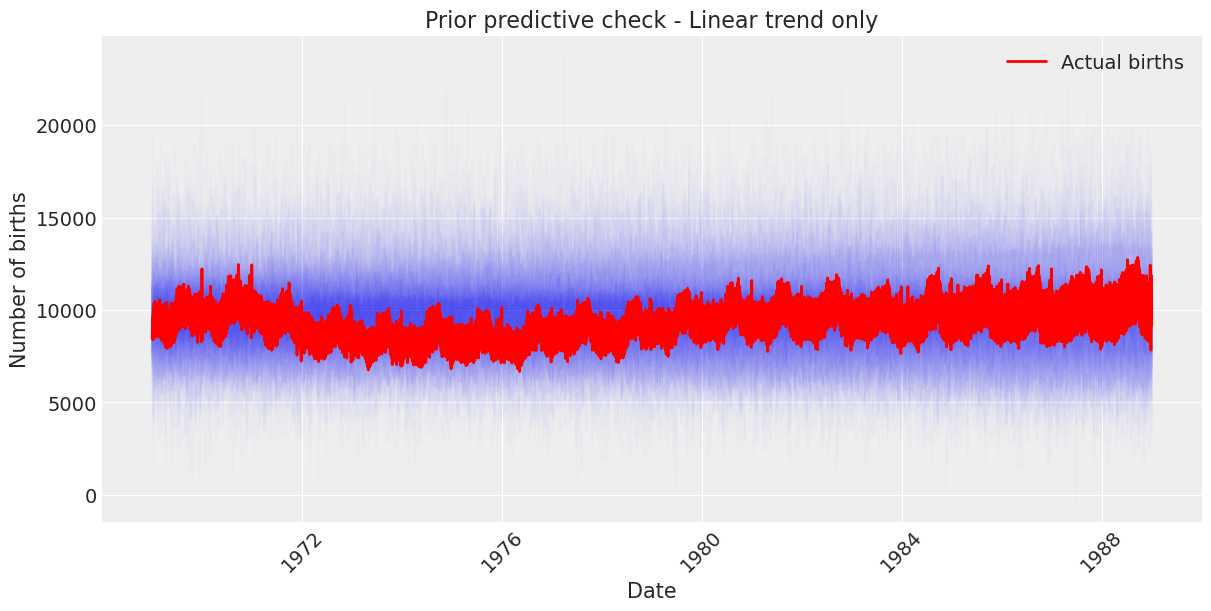

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))

prior_samples = prior_pred.prior_predictive["likelihood"].values[0]
for i in range(100):
    ax.plot(daily_births['date'], prior_samples[i] * y_std + y_mean, alpha=0.01, color="blue")

ax.plot(daily_births['date'], y, color="red", linewidth=2, label="Actual births")
ax.set_xlabel("Date")
ax.set_ylabel("Number of births")
ax.set_title("Prior predictive check - Linear trend only")
ax.legend()
plt.xticks(rotation=45);

In [7]:
with linear:
    trace_linear = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)
    post_pred_linear = pm.sample_posterior_predictive(trace_linear, random_seed=RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [likelihood]


Output()

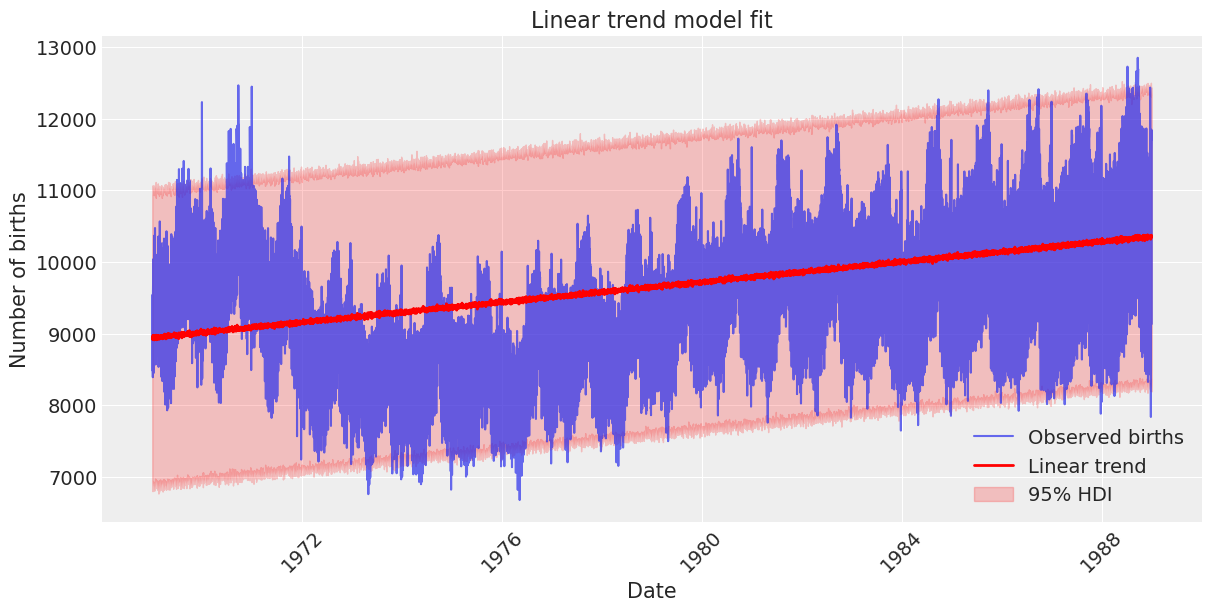

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))

post_samples = post_pred_linear.posterior_predictive["likelihood"].values
post_mean = post_samples.mean(axis=(0, 1))
post_mean_rescaled = post_mean * y_std + y_mean

post_samples_flat = post_samples.reshape(-1, post_samples.shape[-1])
post_lower = np.percentile(post_samples_flat, 2.5, axis=0) * y_std + y_mean
post_upper = np.percentile(post_samples_flat, 97.5, axis=0) * y_std + y_mean

ax.plot(daily_births['date'], y, alpha=0.7, label="Observed births")
ax.plot(daily_births['date'], post_mean_rescaled, color="red", linewidth=2, label="Linear trend")
ax.fill_between(daily_births['date'], post_lower, post_upper, color="red", alpha=0.2, label="95% HDI")
ax.set_xlabel("Date")
ax.set_ylabel("Number of births")
ax.set_title("Linear trend model fit")
ax.legend()
plt.xticks(rotation=45);

The linear trend model captures the overall increase in births over the 20-year period, but the **wide credible intervals** and clear **systematic patterns** in the observed data tell us we're missing important structure. The oscillating patterns visible in the time series suggest the presence of **seasonal effects**—regular, repeating patterns that occur with a fixed period.

In time series analysis, we often encounter multiple overlapping periodicities. For birth data, we might expect patterns repeating every year (seasonal conception patterns), every week (hospital scheduling), and potentially at other frequencies. Our next step is to extend the model to capture these periodic components.

## Modeling Seasonality with Fourier Series

To capture periodic patterns, we turn to a powerful mathematical tool: **Fourier series**. The key insight is that any periodic function can be represented as a sum of sine and cosine waves of different frequencies. This decomposition, named after Joseph Fourier, allows us to model complex seasonal patterns using simple building blocks.

For a function with period $P$, we can write:

$$f(t) = a_0 + \sum_{n=1}^{N} \left[ a_n \cos\left(\frac{2\pi n t}{P}\right) + b_n \sin\left(\frac{2\pi n t}{P}\right) \right]$$

where $N$ is the **order** of the approximation (how many frequency components we include), and $a_n$ and $b_n$ are coefficients that determine the contribution of each frequency.

This approach, popularized by Facebook's Prophet model, has several advantages for time series modeling:

1. **Flexibility**: By including more terms (higher $N$), we can capture increasingly complex patterns
2. **Periodicity**: The resulting function is guaranteed to repeat with period $P$
3. **Smoothness**: Fourier series naturally produce smooth, continuous functions
4. **Orthogonality**: The sine and cosine basis functions are orthogonal, making parameter estimation more stable

For birth data, we expect **annual seasonality** with a period of 365.25 days. Let's start by adding this component to our model:

$$y_t = \alpha + \beta \cdot t + \sum_{n=1}^{N} \left[ a_n \cos\left(\frac{2\pi n \cdot \text{day\_of\_year}_t}{365.25}\right) + b_n \sin\left(\frac{2\pi n \cdot \text{day\_of\_year}_t}{365.25}\right) \right] + \epsilon_t$$

We'll use $N = 10$ terms initially, which allows the model to capture patterns that repeat up to 10 times per year while maintaining smoothness.

In [9]:
day_of_year = daily_births['date'].dt.dayofyear.values
n_order_annual = 10  

fourier_features_list = []
for i in range(1, n_order_annual + 1):
    fourier_features_list.append(np.sin(2 * np.pi * i * day_of_year / 365.25))
    fourier_features_list.append(np.cos(2 * np.pi * i * day_of_year / 365.25))

fourier_features = np.column_stack(fourier_features_list)
n_features = fourier_features.shape[1]

The Fourier features represent periodic oscillations with increasing frequencies. Observe that the sine and cosine features are out-of-phase versions of each other. The key property that makes Fourier features powerful is that any linear combination of these features will be periodic. The period of the resulting function is determined by the lowest frequency used in the feature set.

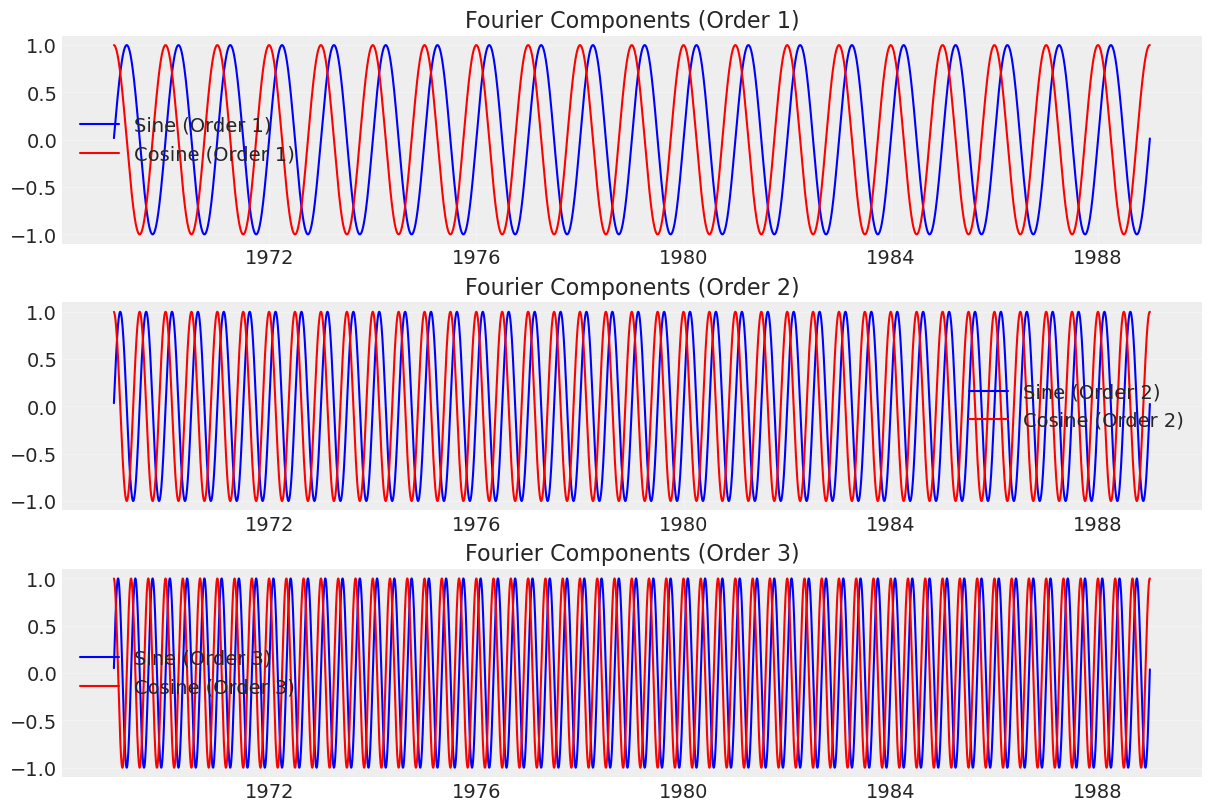

In [10]:
plt.figure(figsize=(12, 8))

for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(daily_births['date'], fourier_features[:, 2*i], color='blue', label=f'Sine (Order {i+1})')
    plt.plot(daily_births['date'], fourier_features[:, 2*i+1], color='red', label=f'Cosine (Order {i+1})')
    plt.title(f'Fourier Components (Order {i+1})')
    plt.grid(True, alpha=0.3)
    plt.legend()

None

The plot above shows the first three pairs of Fourier basis functions. Notice how each successive order oscillates more rapidly: the first-order terms complete one cycle per year, the second-order terms complete two cycles, and so on. The **sine and cosine pairs** are phase-shifted versions of each other—this is crucial because it allows the model to represent a periodic pattern that can peak at any time of year, not just at fixed points determined by our choice of when $t=0$.

When we combine these basis functions with learned weights, the model can construct complex seasonal patterns. The Bayesian framework will automatically determine which frequencies are most important by learning appropriate weights from the data.

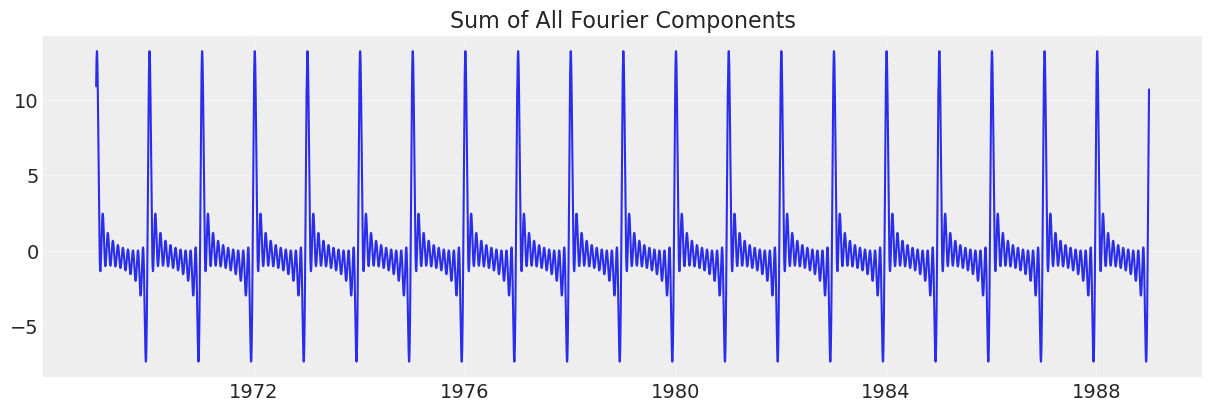

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(daily_births['date'], fourier_features.sum(axis=1))
plt.title('Sum of All Fourier Components')
plt.grid(True, alpha=0.3);

Looking at the sum of all Fourier components with equal weights reveals the rich complexity that emerges from combining simple periodic functions. In practice, the model will learn a **weighted combination** of these features, emphasizing some frequencies while diminishing others to best match the observed seasonal pattern in births.

The power of this approach becomes clear when we fit the model: the posterior distribution will tell us not just what the seasonal pattern looks like, but also our **uncertainty** about that pattern. Components with strong signals in the data will have tightly constrained coefficients, while unnecessary components will have coefficients centered near zero.

In [12]:
coords = {"fourier_features": np.arange(n_features)}

with pm.Model(check_bounds=False, coords=coords) as seasonal_model:
    
    # Priors for trend
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)
    trend = pm.Deterministic("trend", alpha + beta * t)

    # Priors for seasonality
    beta_fourier = pm.Normal("beta_fourier", mu=0, sigma=0.1, dims="fourier_features")
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(beta_fourier, fourier_features.T)
    )

    mu = trend + seasonality
    
    sigma = pm.HalfNormal("sigma", sigma=1)

    pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y_scaled)

    prior_pred_seasonal = pm.sample_prior_predictive(1000, random_seed=RANDOM_SEED)

Sampling: [alpha, beta, beta_fourier, likelihood, sigma]


Prior predictive samples for this model look reasonable:

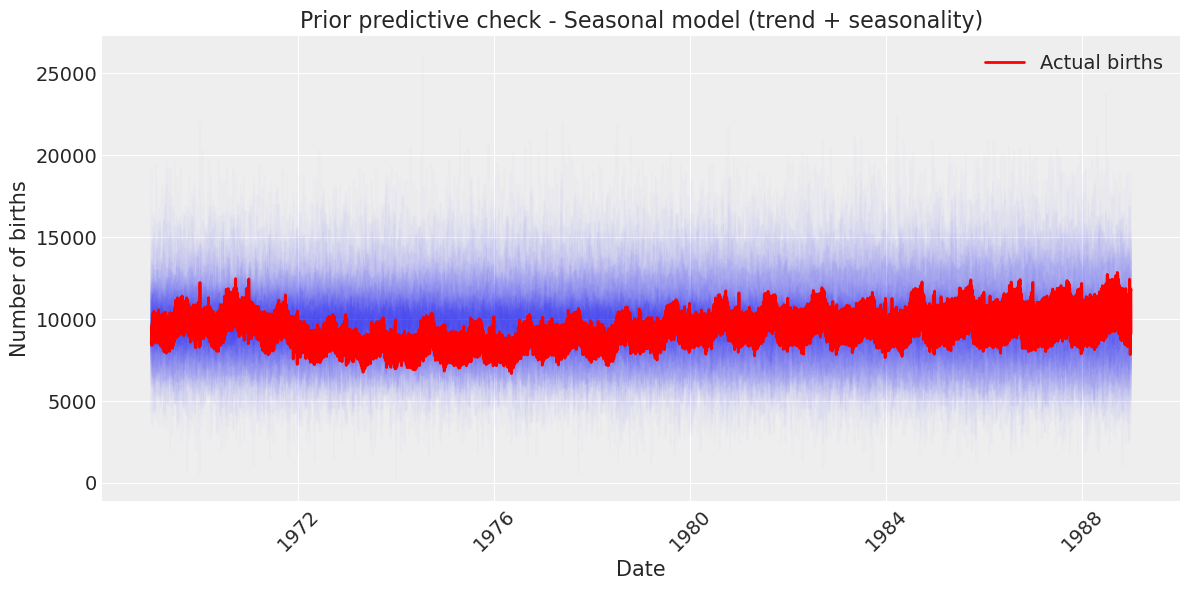

In [13]:
# Plot prior predictive for full model
fig, ax = plt.subplots(figsize=(12, 6))

# Plot some prior predictions
prior_samples_full = prior_pred_seasonal.prior_predictive["likelihood"].values[0]
for i in range(100):
    ax.plot(daily_births['date'], prior_samples_full[i] * y_std + y_mean, alpha=0.01, color="blue")

# Plot actual data
ax.plot(daily_births['date'], y, color="red", linewidth=2, label="Actual births")
ax.set_xlabel("Date")
ax.set_ylabel("Number of births")
ax.set_title("Prior predictive check - Seasonal model (trend + seasonality)")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
with seasonal_model:

    trace_seasonal = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)

    post_pred_seasonal = pm.sample_posterior_predictive(trace_seasonal, random_seed=RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, beta_fourier, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [likelihood]


Output()

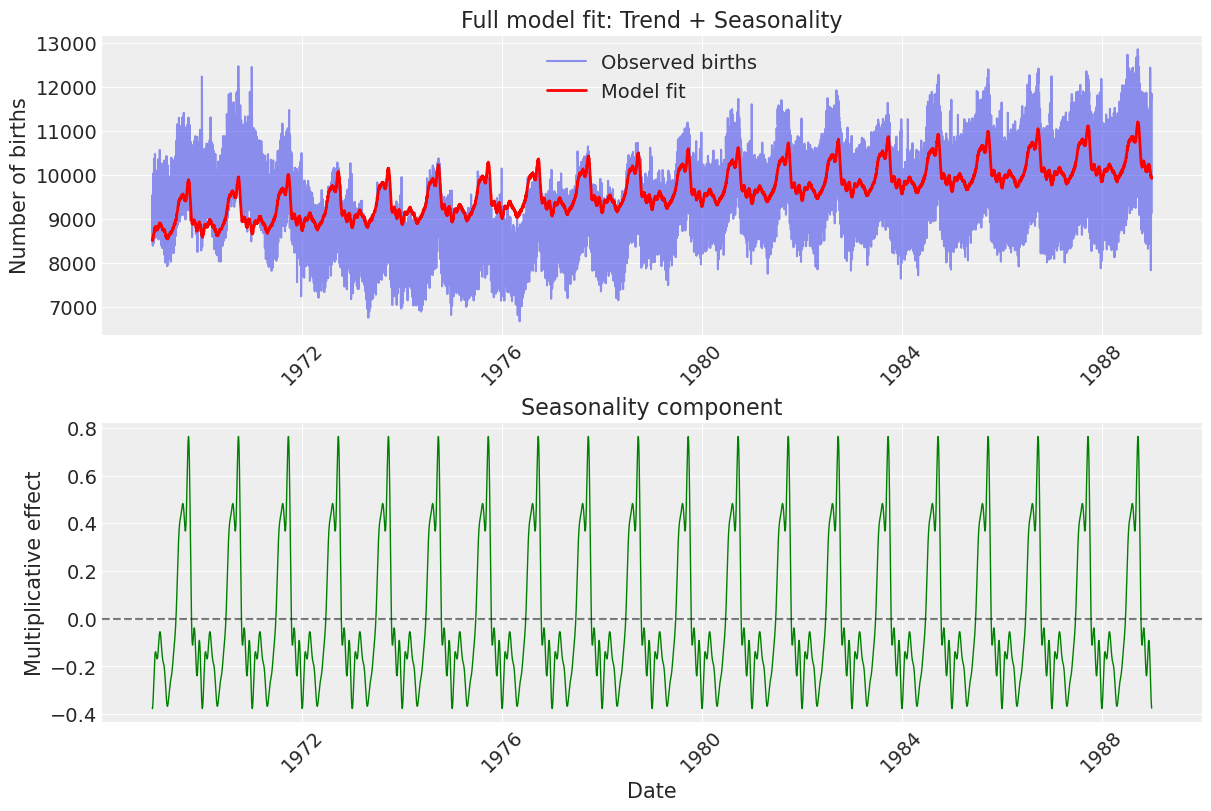

In [15]:
# Plot the fitted model
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Get posterior predictions
post_mean_seasonal = post_pred_seasonal.posterior_predictive["likelihood"].mean(dim=["chain", "draw"]).values
post_mean_seasonal_rescaled = post_mean_seasonal * y_std + y_mean

# Get components
seasonality_mean = trace_seasonal.posterior["seasonality"].mean(dim=["chain", "draw"]).values

# Plot 1: Full model fit
ax1.plot(daily_births['date'], y, alpha=0.5, label="Observed births")
ax1.plot(daily_births['date'], post_mean_seasonal_rescaled, color="red", linewidth=2, label="Model fit")
ax1.set_ylabel("Number of births")
ax1.set_title("Full model fit: Trend + Seasonality")
ax1.legend()

# Plot 2: Seasonality component
ax2.plot(daily_births['date'], seasonality_mean, color="green", linewidth=1)
ax2.set_xlabel("Date")
ax2.set_ylabel("Multiplicative effect")
ax2.set_title("Seasonality component")
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)

for ax in [ax1, ax2]:
    ax.tick_params(axis='x', rotation=45);

So, the model is not yet where we want it to be, but we are slowly chipping away at the components of variation.

The addition of annual seasonality represents a significant improvement over the linear trend model. The seasonal component successfully captures the within-year variation, showing higher birth rates in late summer and early fall (roughly September-October) and lower rates in early spring. This pattern aligns with known demographic trends and the "December conception peak" that leads to September births.

However, careful examination of the model fit reveals we're still missing important structure. The model captures the dominant annual cycle but doesn't account for the **day-of-week patterns** clearly visible in the zoomed views, nor does it handle the dramatic drops in births around **holidays**. Additionally, there may be patterns at other time scales—both shorter (weekly) and longer (multi-year) that could improve our model further.

## Building a Comprehensive Model

Real-world time series often exhibit patterns at multiple time scales simultaneously. Birth data is particularly rich in this regard, influenced by biological, social, medical, and economic factors operating on different frequencies. Let's build a more comprehensive model that captures these various effects.

Our enhanced model will include several types of seasonal patterns:

**1. Annual Seasonality (Higher Order)**: By increasing from 10 to 15 Fourier terms, we allow the model to capture more nuanced within-year patterns. This helps model phenomena like the "wedding season" effect on conception timing or temperature-related conception patterns.

**2. Sub-annual (6-month) Seasonality**: Some patterns repeat twice per year. For instance, there might be conception peaks related to major holiday periods (winter holidays and summer vacations) that create a bi-annual birth pattern.

**3. Weekly Seasonality**: This captures the strong **medical scheduling effects**. Modern obstetric practice involves many scheduled procedures, leading to fewer births on weekends. We model this with day-of-week Fourier features.

**4. Multi-year Cycles**: Demographics and society change on longer timescales. Economic cycles, generational effects, and evolving social norms can create patterns spanning several years.

**5. Decadal Cycles**: Even longer patterns emerge from major societal shifts. The post-war baby boom echo, economic recessions, and changing family planning practices create very long-term oscillations. We include periods of 8.5, 10.5, and 11.8 years based on known demographic and economic cycles.

**6. Holiday Effects**: Major holidays see dramatic reductions in births due to scheduling. We model these as **indicator variables** that allow the birth rate to drop on specific dates.

The full model becomes:

$$y_t = \text{trend}(t) + \text{annual}(t) + \text{biannual}(t) + \text{weekly}(t) + \text{multiyear}(t) + \text{decadal}(t) + \text{holidays}(t) + \epsilon_t$$

where each component is a sum of Fourier terms or indicator functions with learned coefficients.

In [16]:
# 1. Annual seasonality with more flexibility (higher order)
day_of_year = daily_births['date'].dt.dayofyear.values
n_order_annual = 15  # Increased from 10 for more flexibility

fourier_features_annual = []
for i in range(1, n_order_annual + 1):
    fourier_features_annual.append(np.sin(2 * np.pi * i * day_of_year / 365.25))
    fourier_features_annual.append(np.cos(2 * np.pi * i * day_of_year / 365.25))

# 2. Sub-annual (6-month) seasonality
fourier_features_biannual = []
for i in range(1, 4):  # 3 orders for 6-month periodicity
    fourier_features_biannual.append(np.sin(2 * np.pi * i * day_of_year / (365.25/2)))
    fourier_features_biannual.append(np.cos(2 * np.pi * i * day_of_year / (365.25/2)))

# 3. Weekly seasonality (day-of-week effects)
day_of_week = daily_births['date'].dt.dayofweek.values  # 0=Monday, 6=Sunday
n_order_weekly = 3

fourier_features_weekly = []
for i in range(1, n_order_weekly + 1):
    fourier_features_weekly.append(np.sin(2 * np.pi * i * day_of_week / 7))
    fourier_features_weekly.append(np.cos(2 * np.pi * i * day_of_week / 7))

# 4. Multi-year seasonality (medium-term cycles)
fourier_features_multiyear = []
for period in [2, 3, 4, 5, 7]:  # Years
    fourier_features_multiyear.append(np.sin(2 * np.pi * years_elapsed / period))
    fourier_features_multiyear.append(np.cos(2 * np.pi * years_elapsed / period))

# 5. NEW: Longer-term decadal cycles (8-12 years)
# These capture economic cycles, demographic shifts, and other long-term patterns
fourier_features_decadal = []
for period in [8.5, 10.5, 11.8]:  # Key longer periods
    for i in range(1, 2):  # Just 1 order each to keep it efficient
        fourier_features_decadal.append(np.sin(2 * np.pi * i * years_elapsed / period))
        fourier_features_decadal.append(np.cos(2 * np.pi * i * years_elapsed / period))

# 6. Holiday indicators
is_new_year = ((daily_births['date'].dt.month == 1) & (daily_births['date'].dt.day == 1)).astype(float)
is_christmas = ((daily_births['date'].dt.month == 12) & (daily_births['date'].dt.day == 25)).astype(float)
is_christmas_eve = ((daily_births['date'].dt.month == 12) & (daily_births['date'].dt.day == 24)).astype(float)
is_july_4th = ((daily_births['date'].dt.month == 7) & (daily_births['date'].dt.day == 4)).astype(float)

# Also create indicators for days around major holidays
is_near_christmas = ((daily_births['date'].dt.month == 12) & 
    (daily_births['date'].dt.day >= 23) & 
    (daily_births['date'].dt.day <= 26)).astype(float)
is_near_new_year = (((daily_births['date'].dt.month == 12) & (daily_births['date'].dt.day >= 30)) |
    ((daily_births['date'].dt.month == 1) & (daily_births['date'].dt.day <= 2))).astype(float)

# Combine all features
all_features = (fourier_features_annual + 
    fourier_features_biannual + 
    fourier_features_weekly + 
    fourier_features_multiyear +
    fourier_features_decadal)  # Added decadal features

fourier_features_all = np.column_stack(all_features)
holiday_features = np.column_stack([is_new_year, is_christmas, is_christmas_eve, 
    is_july_4th, is_near_christmas, is_near_new_year])

n_fourier = fourier_features_all.shape[1]
n_holidays = holiday_features.shape[1]

print(f"\nFeature counts:")
print(f"  Annual Fourier features: {len(fourier_features_annual)}")
print(f"  Bi-annual Fourier features: {len(fourier_features_biannual)}")
print(f"  Weekly Fourier features: {len(fourier_features_weekly)}")
print(f"  Multi-year Fourier features: {len(fourier_features_multiyear)}")
print(f"  Decadal Fourier features: {len(fourier_features_decadal)}")
print(f"  Holiday features: {n_holidays}")
print(f"  Total features: {n_fourier + n_holidays}")


Feature counts:
  Annual Fourier features: 30
  Bi-annual Fourier features: 6
  Weekly Fourier features: 6
  Multi-year Fourier features: 10
  Decadal Fourier features: 6
  Holiday features: 6
  Total features: 64


In [17]:
# Build the enhanced model with bias adjustment
coords_enhanced = {
    "fourier_features": np.arange(n_fourier),
    "holiday_features": np.arange(n_holidays),
    "holiday_names": ["New Year", "Christmas", "Christmas Eve", "July 4th", "Near Christmas", "Near New Year"]
}

with pm.Model(check_bounds=False, coords=coords_enhanced) as enhanced_model:

    # Priors for trend 
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)
    
    # Add a quadratic term for non-linear trend
    beta2 = pm.Normal("beta2", mu=0, sigma=0.5)
    trend = pm.Deterministic("trend", alpha + beta * t + beta2 * t**2)

    # Priors for Fourier features
    beta_fourier = pm.Normal("beta_fourier", mu=0, sigma=0.1, dims="fourier_features")
    
    # Bookkeeping the Fourier features
    idx = 0
    beta_annual = beta_fourier[idx:idx+len(fourier_features_annual)]
    idx += len(fourier_features_annual)
    beta_biannual = beta_fourier[idx:idx+len(fourier_features_biannual)]
    idx += len(fourier_features_biannual)
    beta_weekly = beta_fourier[idx:idx+len(fourier_features_weekly)]
    idx += len(fourier_features_weekly)
    beta_multiyear = beta_fourier[idx:idx+len(fourier_features_multiyear)]
    idx += len(fourier_features_multiyear)
    beta_decadal = beta_fourier[idx:idx+len(fourier_features_decadal)]
    
    annual_seasonality = pm.math.dot(beta_annual, np.column_stack(fourier_features_annual).T)
    biannual_seasonality = pm.math.dot(beta_biannual, np.column_stack(fourier_features_biannual).T)
    weekly_seasonality = pm.math.dot(beta_weekly, np.column_stack(fourier_features_weekly).T)
    multiyear_seasonality = pm.math.dot(beta_multiyear, np.column_stack(fourier_features_multiyear).T)
    decadal_seasonality = pm.math.dot(beta_decadal, np.column_stack(fourier_features_decadal).T)
    
    beta_holidays = pm.Normal("beta_holidays", mu=-0.3, sigma=0.2, dims="holiday_features")
    holiday_effect = pm.math.dot(beta_holidays, holiday_features.T)

    total_seasonality = pm.Deterministic(
        "total_seasonality",
        annual_seasonality + 
        biannual_seasonality + 
        weekly_seasonality + 
        multiyear_seasonality + 
        decadal_seasonality
    )
    
    mu = trend + total_seasonality + holiday_effect 

    sigma = pm.HalfNormal("sigma", sigma=0.1)

    pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y_scaled)

In [18]:
with enhanced_model:
    trace_enhanced = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)

    post_pred_enhanced = pm.sample_posterior_predictive(trace_enhanced, random_seed=RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, beta2, beta_fourier, beta_holidays, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 96 seconds.
Sampling: [likelihood]


Output()

### Model fit

In [19]:
# Calculate the mean prediction and rescale to original units
post_mean_enhanced = post_pred_enhanced.posterior_predictive["likelihood"].mean(dim=["chain", "draw"]).values
post_mean_enhanced_rescaled = post_mean_enhanced * y_std + y_mean

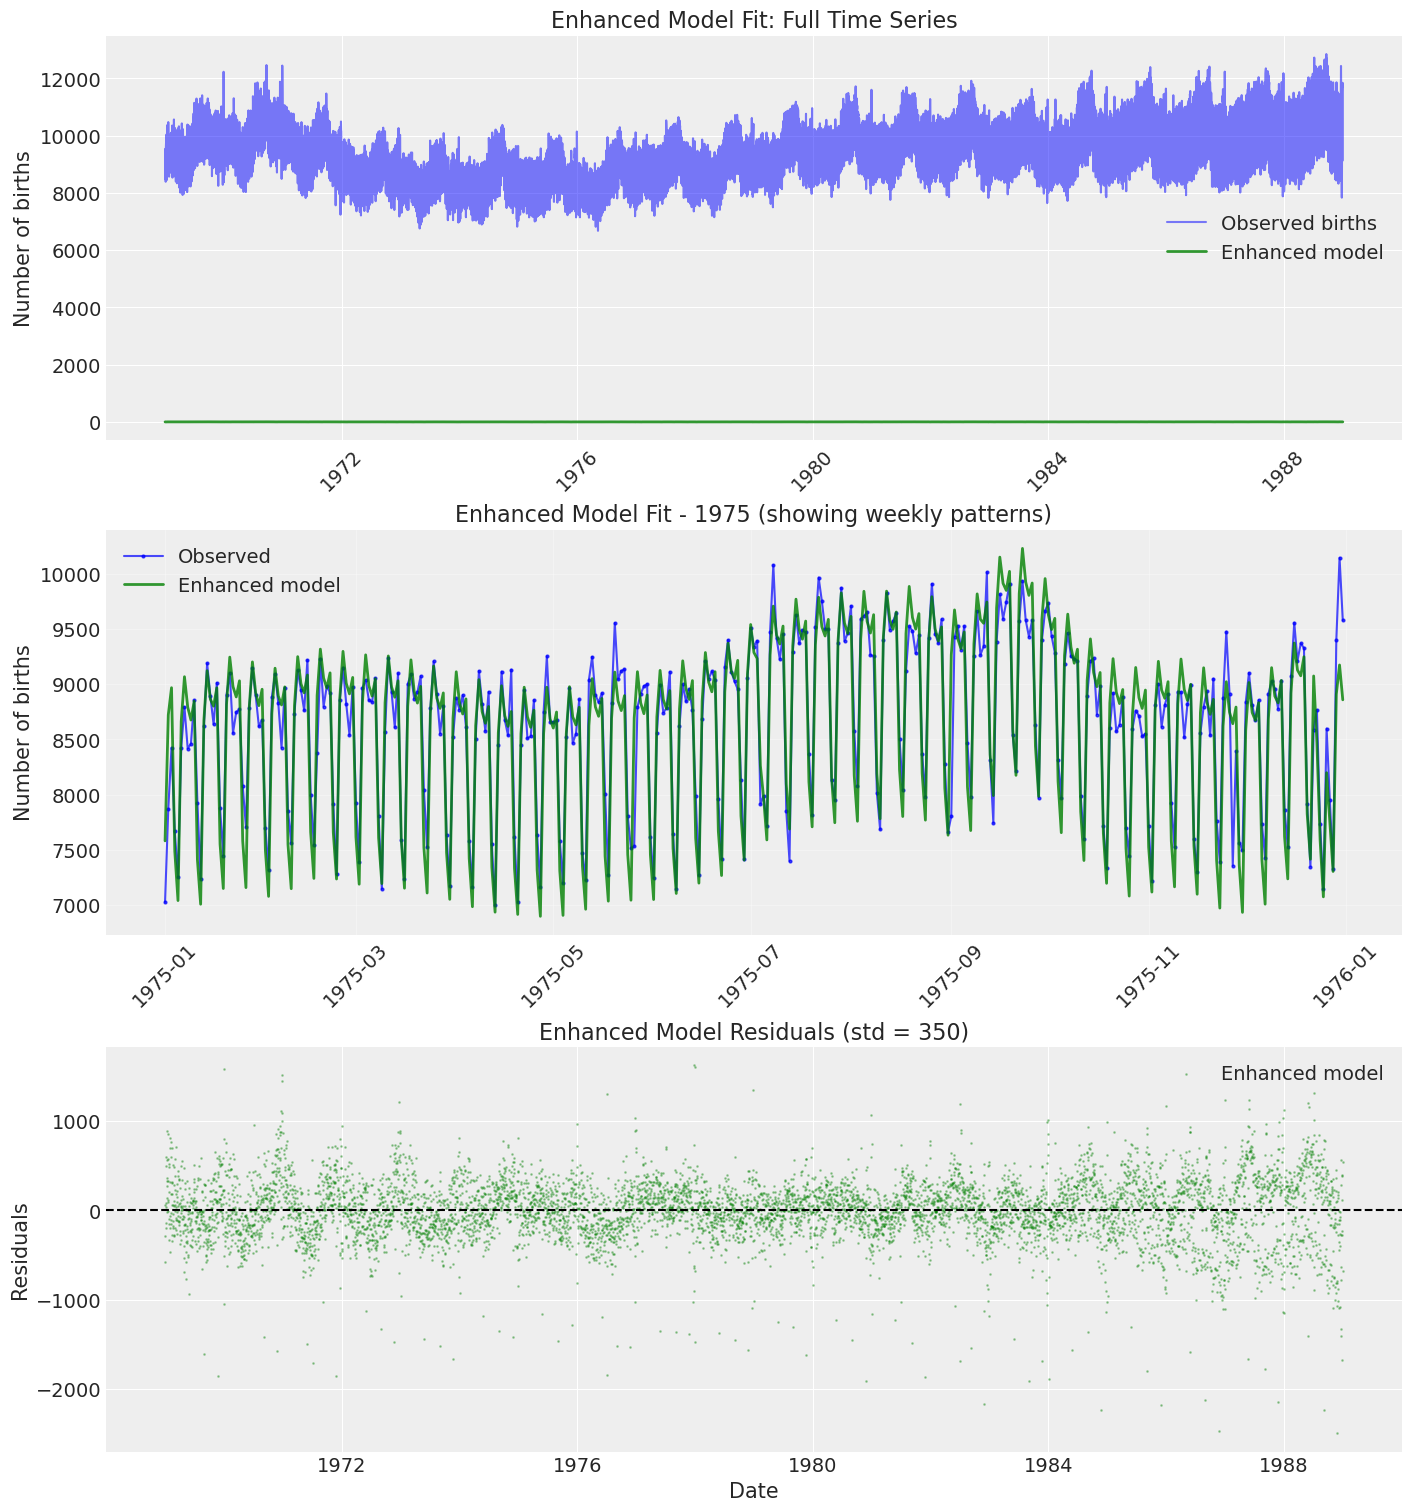

In [20]:
# Create plots for the enhanced model
fig, axes = plt.subplots(3, 1, figsize=(14, 15))

# Plot 1: Enhanced model fit
axes[0].plot(daily_births['date'], y, alpha=0.5, label="Observed births", color='blue')
axes[0].plot(daily_births['date'], post_mean_enhanced, color="green", linewidth=2, 
             label="Enhanced model", alpha=0.8)
axes[0].set_ylabel("Number of births")
axes[0].set_title("Enhanced Model Fit: Full Time Series")
axes[0].legend()

# Plot 2: Zoom on 1975 to see weekly patterns
zoom_start = pd.to_datetime('1975-01-01')
zoom_end = pd.to_datetime('1975-12-31')
zoom_mask = (daily_births['date'] >= zoom_start) & (daily_births['date'] <= zoom_end)

axes[1].plot(daily_births['date'][zoom_mask], y[zoom_mask], alpha=0.7, label="Observed", 
             marker='o', markersize=2, color='blue')
axes[1].plot(daily_births['date'][zoom_mask], post_mean_enhanced_rescaled[zoom_mask], 
             color="green", linewidth=2, label="Enhanced model", alpha=0.8)
axes[1].set_ylabel("Number of births")
axes[1].set_title("Enhanced Model Fit - 1975 (showing weekly patterns)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Enhanced model residuals
post_mean_enhanced = post_pred_enhanced.posterior_predictive["likelihood"].mean(dim=["chain", "draw"]).values
post_mean_enhanced_rescaled = post_mean_enhanced * y_std + y_mean
residuals_enhanced = y - post_mean_enhanced_rescaled

axes[2].scatter(daily_births['date'], residuals_enhanced, alpha=0.3, s=1, color='green', label='Enhanced model')
axes[2].axhline(y=0, color='black', linestyle='--')
axes[2].set_ylabel("Residuals")
axes[2].set_xlabel("Date")
axes[2].set_title(f"Enhanced Model Residuals (std = {residuals_enhanced.std():.0f})")
axes[2].legend()

for ax in axes[:2]:
    ax.tick_params(axis='x', rotation=45);

### Holiday Effects

The comprehensive model includes specific indicators for major holidays, allowing us to quantify their impact on birth patterns. Let's examine how well the model captures these sharp, localized drops in births around Christmas, New Year's Day, and Independence Day using a couple of arbitrarily-chosen years. These holiday effects are particularly interesting because they represent **discrete shocks** to the system rather than smooth periodic patterns.

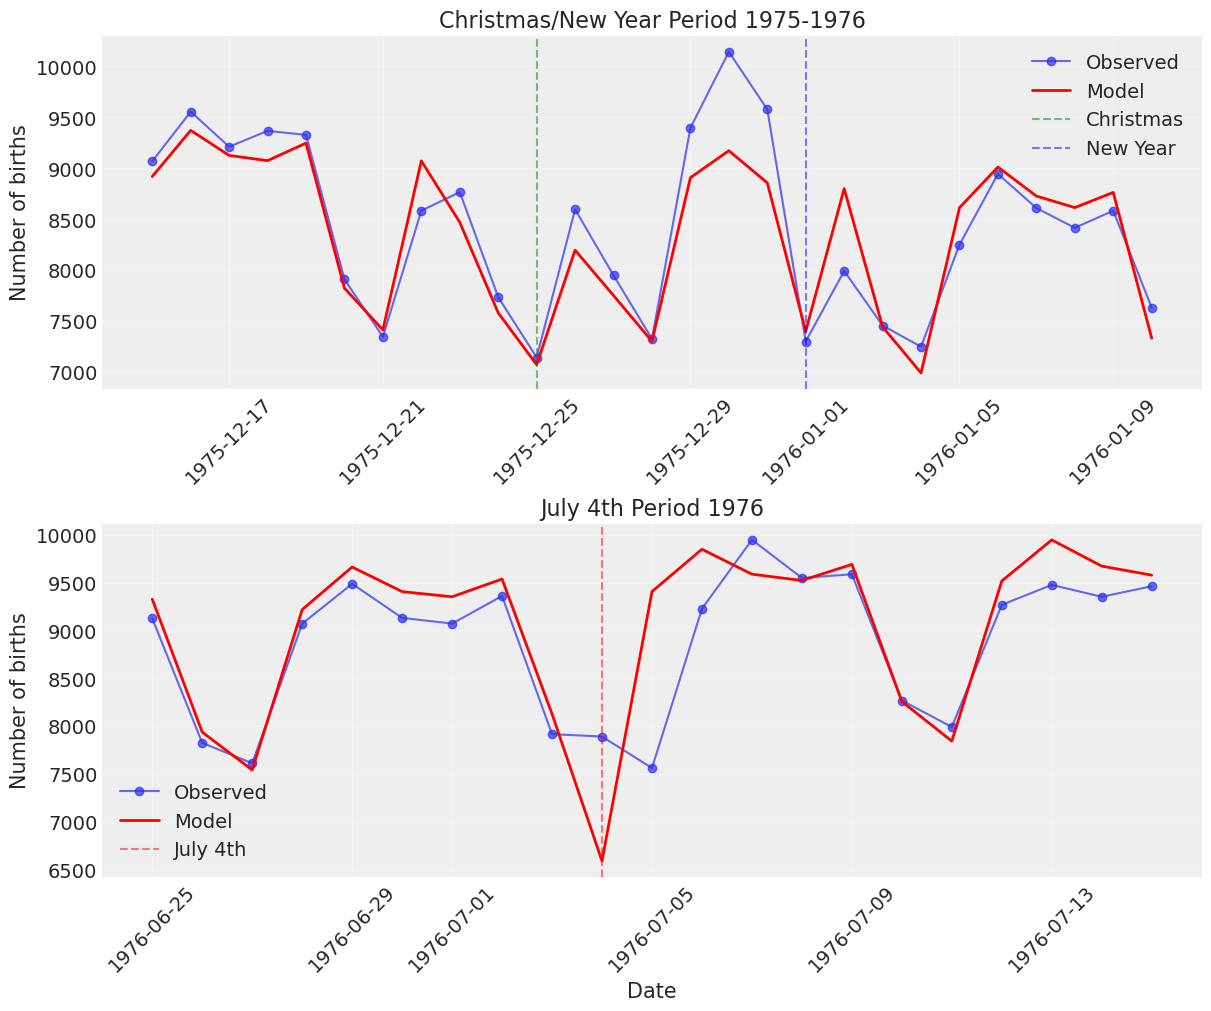

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Christmas 1975
xmas_start = pd.to_datetime('1975-12-15')
xmas_end = pd.to_datetime('1976-01-10')
xmas_mask = (daily_births['date'] >= xmas_start) & (daily_births['date'] <= xmas_end)

axes[0].plot(daily_births['date'][xmas_mask], y[xmas_mask], 'o-', alpha=0.7, label="Observed")
axes[0].plot(daily_births['date'][xmas_mask], post_mean_enhanced_rescaled[xmas_mask], 
             'r-', linewidth=2, label="Model")
axes[0].axvline(pd.to_datetime('1975-12-25'), color='green', linestyle='--', alpha=0.5, label='Christmas')
axes[0].axvline(pd.to_datetime('1976-01-01'), color='blue', linestyle='--', alpha=0.5, label='New Year')
axes[0].set_ylabel("Number of births")
axes[0].set_title("Christmas/New Year Period 1975-1976")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# July 4th 1976
july_start = pd.to_datetime('1976-06-25')
july_end = pd.to_datetime('1976-07-15')
july_mask = (daily_births['date'] >= july_start) & (daily_births['date'] <= july_end)

axes[1].plot(daily_births['date'][july_mask], y[july_mask], 'o-', alpha=0.7, label="Observed")
axes[1].plot(daily_births['date'][july_mask], post_mean_enhanced_rescaled[july_mask], 
             'r-', linewidth=2, label="Model")
axes[1].axvline(pd.to_datetime('1976-07-04'), color='red', linestyle='--', alpha=0.5, label='July 4th')
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Number of births")
axes[1].set_title("July 4th Period 1976")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

for ax in axes:
    ax.tick_params(axis='x', rotation=45);

### Weekly Pattern Analysis

One of the most striking features of the birth data is the strong **weekly periodicity**. By extracting the learned coefficients for the weekly Fourier features, we can visualize exactly how the model perceives the day-of-week effect. This decomposition provides a cleaner view than the raw averages we computed earlier, as it controls for other sources of variation like trends and annual seasonality.

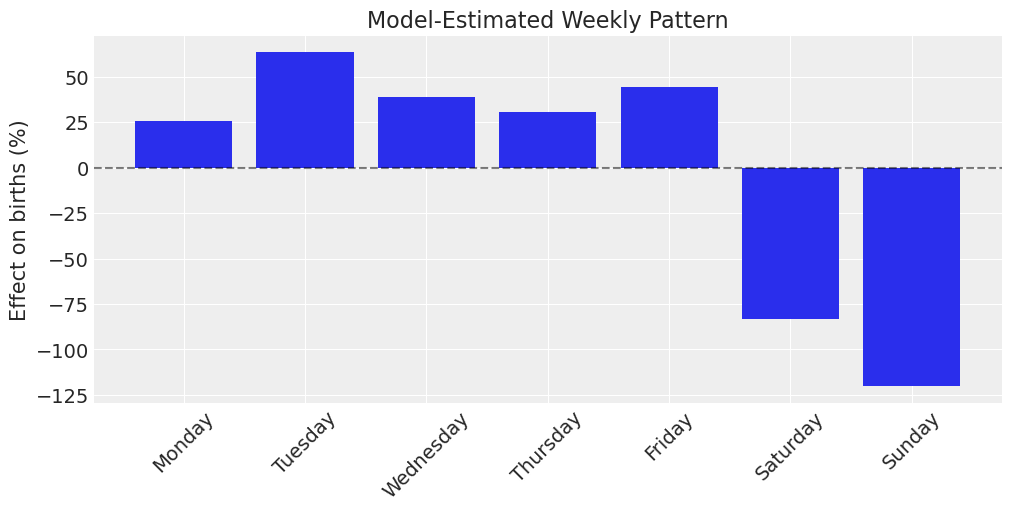

In [22]:
# Extract and visualize the weekly pattern
# Create a synthetic week to show the pattern
synthetic_week_days = np.arange(7)
synthetic_week_features = []

for i in range(1, n_order_weekly + 1):
    synthetic_week_features.append(np.sin(2 * np.pi * i * synthetic_week_days / 7))
    synthetic_week_features.append(np.cos(2 * np.pi * i * synthetic_week_days / 7))

# Get the weekly coefficients
idx_start = len(fourier_features_annual) + len(fourier_features_biannual)
idx_end = idx_start + len(fourier_features_weekly)
weekly_coeffs = trace_enhanced.posterior["beta_fourier"].mean(dim=["chain", "draw"]).values[idx_start:idx_end]

# Calculate the weekly pattern
weekly_pattern = np.dot(weekly_coeffs, np.column_stack(synthetic_week_features).T)
weekly_pattern_pct = weekly_pattern * 100  # Convert to percentage

# Plot the weekly pattern
plt.figure(figsize=(10, 5))
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.bar(days, weekly_pattern_pct)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.ylabel('Effect on births (%)')
plt.title('Model-Estimated Weekly Pattern')
plt.xticks(rotation=45);

By decomposing the time series into interpretable components, we've gained insights that would be hidden in a black-box approach. The model reveals that weekday births are elevated by approximately 25-70% compared to the baseline, while Sunday births drop by over 80%. This dramatic pattern reflects the reality of modern obstetric practice, where scheduled procedures dominate weekday deliveries. Similarly, the holiday effects show even more extreme reductions, with some holidays seeing birth rates fall to less than 70% of normal levels.

## Building a Forecasting Model with pm.Data

In the previous section, we saw how to use a "dummy model" to generate forecasts. Another approach is to use `pm.Data` containers for all input data. This allows us to easily update the data for forecasting without redefining the model.

To demonstrate, let's generate a forecast from our generative model.

Start by splitting off a test set from the end of the time series.

In [ ]:
n_train = int(0.8 * len(y_scaled))
train_idx = np.arange(n_train)
test_idx = np.arange(n_train, len(y_scaled))

t_train, t_test = t[train_idx], t[test_idx]
y_scaled_train, y_scaled_test = y_scaled[train_idx], y_scaled[test_idx]

fourier_features_annual_train = [f[train_idx] for f in fourier_features_annual]
fourier_features_annual_test = [f[test_idx] for f in fourier_features_annual]

fourier_features_biannual_train = [f[train_idx] for f in fourier_features_biannual]
fourier_features_biannual_test = [f[test_idx] for f in fourier_features_biannual]

fourier_features_weekly_train = [f[train_idx] for f in fourier_features_weekly]
fourier_features_weekly_test = [f[test_idx] for f in fourier_features_weekly]

fourier_features_multiyear_train = [f[train_idx] for f in fourier_features_multiyear]
fourier_features_multiyear_test = [f[test_idx] for f in fourier_features_multiyear]

fourier_features_decadal_train = [f[train_idx] for f in fourier_features_decadal]
fourier_features_decadal_test = [f[test_idx] for f in fourier_features_decadal]

holiday_features_train = holiday_features[train_idx]
holiday_features_test = holiday_features[test_idx]

fourier_features_all_train = np.column_stack([f for features in 
    [fourier_features_annual_train, fourier_features_biannual_train, 
     fourier_features_weekly_train, fourier_features_multiyear_train,
     fourier_features_decadal_train] for f in features])
fourier_features_all_test = np.column_stack([f for features in 
    [fourier_features_annual_test, fourier_features_biannual_test, 
     fourier_features_weekly_test, fourier_features_multiyear_test,
     fourier_features_decadal_test] for f in features])

Now, we wrap all of the input data in `pm.Data` containers. This essentially adds the data as nodes in the PyMC graph, and allows us to update the model with new data later on.

In [ ]:
with pm.Model(check_bounds=False, coords=coords_enhanced) as enhanced_model:
    
    t_data = pm.Data("t_data", t_train)
    y_scaled_data = pm.Data("y_scaled_data", y_scaled_train)
    fourier_annual_data = pm.Data("fourier_annual_data", np.column_stack(fourier_features_annual_train))
    fourier_biannual_data = pm.Data("fourier_biannual_data", np.column_stack(fourier_features_biannual_train))
    fourier_weekly_data = pm.Data("fourier_weekly_data", np.column_stack(fourier_features_weekly_train))
    fourier_multiyear_data = pm.Data("fourier_multiyear_data", np.column_stack(fourier_features_multiyear_train))
    fourier_decadal_data = pm.Data("fourier_decadal_data", np.column_stack(fourier_features_decadal_train))
    holiday_data = pm.Data("holiday_data", holiday_features_train)

    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)
    
    beta2 = pm.Normal("beta2", mu=0, sigma=0.5)
    trend = pm.Deterministic("trend", alpha + beta * t_data + beta2 * t_data**2)

    beta_fourier = pm.Normal("beta_fourier", mu=0, sigma=0.1, dims="fourier_features")
    
    idx = 0
    beta_annual = beta_fourier[idx:idx+fourier_annual_data.shape[1]]
    idx += fourier_annual_data.shape[1]
    beta_biannual = beta_fourier[idx:idx+fourier_biannual_data.shape[1]]
    idx += fourier_biannual_data.shape[1]
    beta_weekly = beta_fourier[idx:idx+fourier_weekly_data.shape[1]]
    idx += fourier_weekly_data.shape[1]
    beta_multiyear = beta_fourier[idx:idx+fourier_multiyear_data.shape[1]]
    idx += fourier_multiyear_data.shape[1]
    beta_decadal = beta_fourier[idx:idx+fourier_decadal_data.shape[1]]
    
    annual_seasonality = pm.math.dot(beta_annual, fourier_annual_data.T)
    biannual_seasonality = pm.math.dot(beta_biannual, fourier_biannual_data.T)
    weekly_seasonality = pm.math.dot(beta_weekly, fourier_weekly_data.T)
    multiyear_seasonality = pm.math.dot(beta_multiyear, fourier_multiyear_data.T)
    decadal_seasonality = pm.math.dot(beta_decadal, fourier_decadal_data.T)
    
    beta_holidays = pm.Normal("beta_holidays", mu=-0.3, sigma=0.2, dims="holiday_features")
    holiday_effect = pm.math.dot(beta_holidays, holiday_data.T)

    total_seasonality = pm.Deterministic(
        "total_seasonality",
        annual_seasonality + 
        biannual_seasonality + 
        weekly_seasonality + 
        multiyear_seasonality + 
        decadal_seasonality
    )
    
    mu = trend + total_seasonality + holiday_effect 

    sigma = pm.HalfNormal("sigma", sigma=0.1)

    pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y_scaled_data)

In [84]:
with enhanced_model:
    trace_enhanced = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, beta2, beta_fourier, beta_holidays, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 97 seconds.


Having done all of that, generating forecasts is a matter of swapping in the test data using `pm.set_data` and then sampling from the posterior predictive distribution.

In [ ]:
with enhanced_model:

    # Update all data containers with test data
    pm.set_data({
        "t_data": t_test,
        # Dummy values since we're predicting these
        "y_scaled_data": np.zeros_like(y_scaled_test),  
        "fourier_annual_data": np.column_stack(fourier_features_annual_test),
        "fourier_biannual_data": np.column_stack(fourier_features_biannual_test),
        "fourier_weekly_data": np.column_stack(fourier_features_weekly_test),
        "fourier_multiyear_data": np.column_stack(fourier_features_multiyear_test),
        "fourier_decadal_data": np.column_stack(fourier_features_decadal_test),
        "holiday_data": holiday_features_test
    })
    
    # Generate posterior predictive samples for the test period
    forecast_samples = pm.sample_posterior_predictive(
        trace_enhanced,
        var_names=["likelihood"],
        random_seed=RANDOM_SEED
    )

Sampling: [likelihood]


Output()

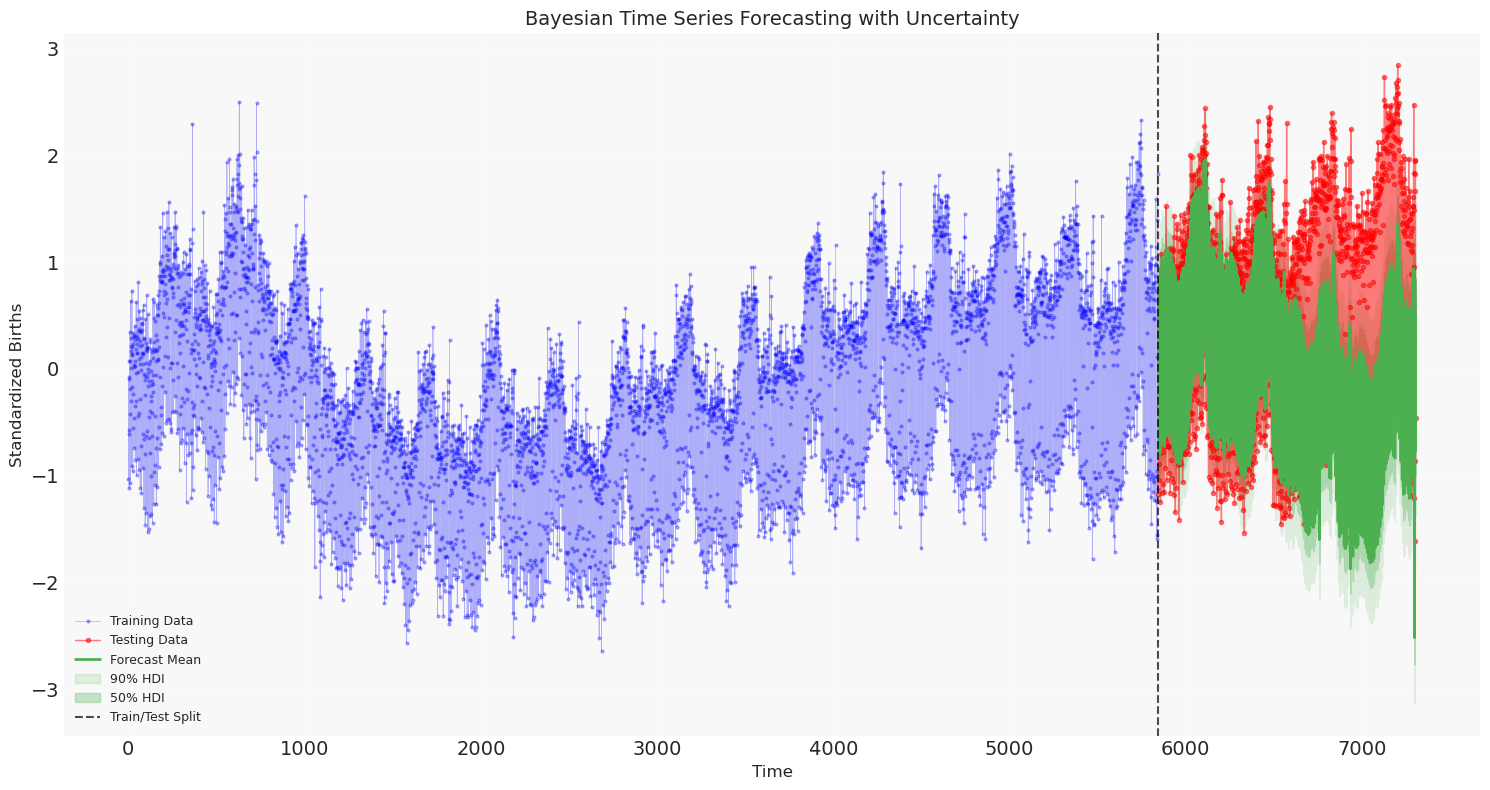

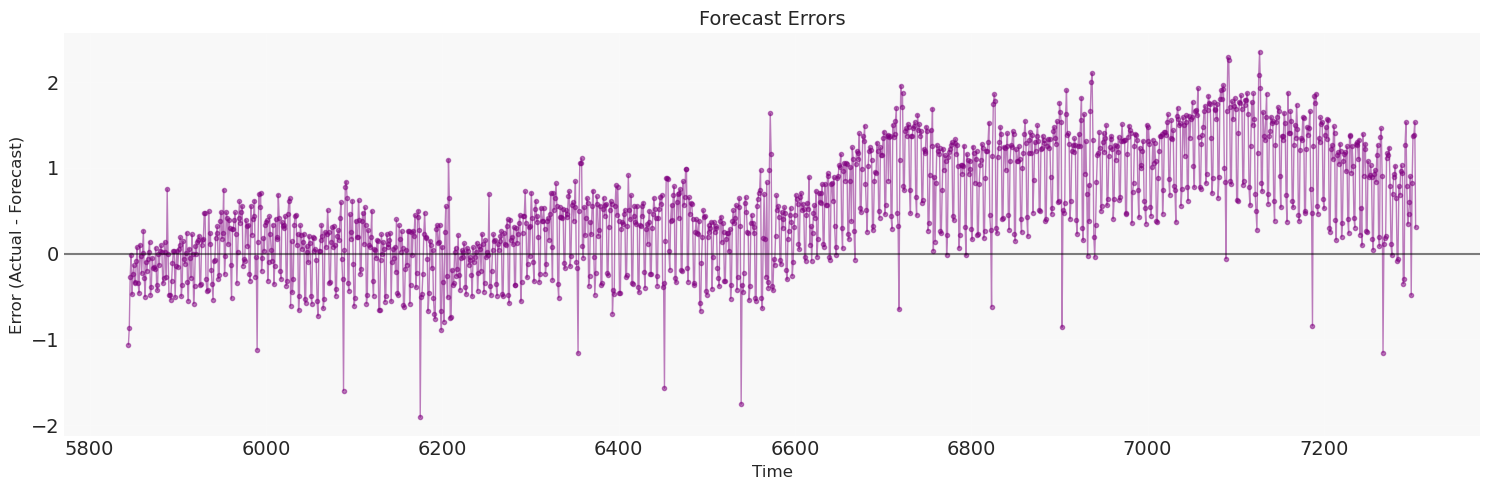

In [ ]:
forecast_samples_array = forecast_samples.posterior_predictive["likelihood"].values
forecast_samples_flat = forecast_samples_array.reshape(-1, len(y_scaled_test))

forecast_mean = np.mean(forecast_samples_flat, axis=0)
forecast_median = np.median(forecast_samples_flat, axis=0)
forecast_hdi_90_lower = np.percentile(forecast_samples_flat, 5, axis=0)
forecast_hdi_90_upper = np.percentile(forecast_samples_flat, 95, axis=0)
forecast_hdi_50_lower = np.percentile(forecast_samples_flat, 25, axis=0)
forecast_hdi_50_upper = np.percentile(forecast_samples_flat, 75, axis=0)

fig, ax = plt.subplots(figsize=(15, 8))

time_all = np.arange(len(y_scaled))
time_train = time_all[:n_train]
time_test = time_all[n_train:]

ax.plot(time_train, y_scaled_train, 'o-', color='blue', alpha=0.3, 
        label='Training Data', markersize=2, linewidth=0.5)

ax.plot(time_test, y_scaled_test, 'o-', color='red', alpha=0.5, 
        label='Testing Data', markersize=3, linewidth=1)

light_green = '#4CAF50'

ax.plot(time_test, forecast_mean, '-', color=light_green, linewidth=2, 
        label='Forecast Mean')

ax.fill_between(time_test, 
                forecast_hdi_90_lower, 
                forecast_hdi_90_upper, 
                alpha=0.15, color=light_green, label='90% HDI')

ax.fill_between(time_test, 
                forecast_hdi_50_lower, 
                forecast_hdi_50_upper, 
                alpha=0.3, color=light_green, label='50% HDI')

ax.axvline(n_train, color='black', linestyle='--', alpha=0.7, label='Train/Test Split')

ax.set_title('Bayesian Time Series Forecasting with Uncertainty', fontsize=14)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Standardized Births', fontsize=12)

ax.legend(loc='best', fontsize=9)

ax.grid(True, alpha=0.15)

ax.set_facecolor('#f8f8f8')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(15, 5))

forecast_errors_standardized = y_scaled_test - forecast_mean
ax.plot(time_test, forecast_errors_standardized, 'o-', color='purple', 
        alpha=0.5, markersize=3, linewidth=1)
ax.axhline(0, color='black', linestyle='-', alpha=0.5)
ax.set_title('Forecast Errors', fontsize=14)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Error (Actual - Forecast)', fontsize=12)
ax.grid(True, alpha=0.15)
ax.set_facecolor('#f8f8f8')

plt.tight_layout()
plt.show()

## Non-parametric Bayesian Models

Use of the term "non-parametric" in the context of Bayesian analysis is something of a misnomer. This is because the first and fundamental step in Bayesian modeling is to specify a *full probability model* for the problem at hand. It is rather difficult to explicitly state a full probability model without the use of probability functions, which are parametric. Bayesian non-parametric methods do not imply that there are no parameters, but rather that the number of parameters grows with the size of the dataset. In fact, Bayesian non-parametric models are *infinitely* parametric.

### Building models with Gaussians

What if we chose to use Gaussian distributions to model our data? 

$$p(x \mid \pi, \Sigma) = (2\pi)^{-k/2}|\Sigma|^{-1/2} \exp\left\{ -\frac{1}{2} (x-\mu)^{\prime}\Sigma^{-1}(x-\mu) \right\}$$

There would not seem to be an advantage to doing this, because normal distributions are not particularly flexible distributions in and of themselves. However, adopting a set of Gaussians (a multivariate normal vector) confers a number of advantages. First, the marginal distribution of any subset of elements from  a multivariate normal distribution is also normal:

$$p(x,y) = \mathcal{N}\left(\left[{
\begin{array}{c}
  {\mu_x}  \\
  {\mu_y}  \\
\end{array}
}\right], \left[{
\begin{array}{c}
  {\Sigma_x} & {\Sigma_{xy}}  \\
  {\Sigma_{xy}^T} & {\Sigma_y}  \\
\end{array}
}\right]\right)$$

$$p(x) = \int p(x,y) dy = \mathcal{N}(\mu_x, \Sigma_x)$$

Also, conditionals distributions of a subset of a multivariate normal distribution (conditional on the remaining elements) are normal too:

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), 
\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$

A Gaussian process generalizes the multivariate normal to infinite dimension. It is defined as an infinite collection of random variables, any finite subset of which have a Gaussian distribution. Thus, the marginalization property is explicit in its definition. Another way of thinking about an infinite vector is as a *function*. When we write a function that takes continuous values as inputs, we are essentially specifying an infinte vector that only returns values (indexed by the inputs) when the function is called upon to do so. By the same token, this notion of an infinite-dimensional Gaussian as a function allows us to work with them computationally: we are never required to store all the elements of the Gaussian process, only to calculate them on demand.

So, we can describe a Gaussian process as a ***disribution over functions***. Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a GP is fully specified by a **mean function** and a **covariance function**:

$$p(x) \sim \mathcal{GP}(m(x), k(x,x^{\prime}))$$

It is the marginalization property that makes working with a Gaussian process feasible: we can marginalize over the infinitely-many variables that we are not interested in, or have not observed. 

For example, one specification of a GP might be as follows:

$$\begin{aligned}
m(x) &=0 \\
k(x,x^{\prime}) &= \theta_1\exp\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right)
\end{aligned}$$

here, the covariance function is a **squared exponential**, for which values of $x$ and $x^{\prime}$ that are close together result in values of $k$ closer to 1 and those that are far apart return values closer to zero. 

In [23]:
def exponential_cov(x, y, scale, length_scale):
    return scale * np.exp( -0.5 * length_scale * np.subtract.outer(x, y)**2)

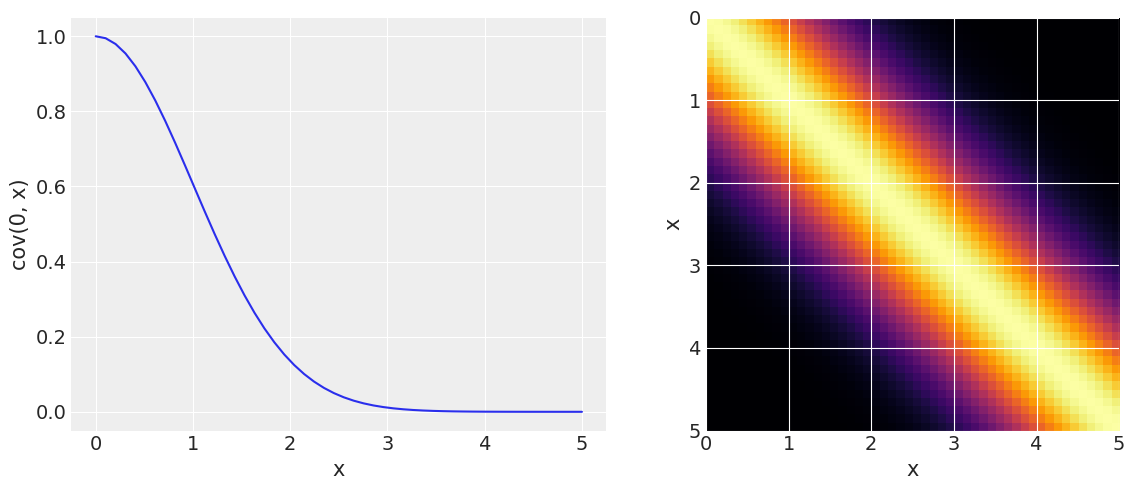

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
xrange = np.linspace(0, 5)
ax1.plot(xrange, exponential_cov(0, xrange, 1, 1))
ax1.set_xlabel('x')
ax1.set_ylabel('cov(0, x)')

z = np.array([exponential_cov(xrange, xprime, 1, 1) for xprime in xrange])
ax2.imshow(z, cmap="inferno", 
       interpolation='none', 
       extent=(0, 5, 5, 0))
ax2.set_xlabel('x')
ax2.set_ylabel('x')

plt.tight_layout();

It may seem odd to simply adopt the zero function to represent the mean function of the Gaussian process -- surely we can do better than that! It turns out that most of the learning in the GP involves the covariance function and its parameters, so very little is gained in specifying a complicated mean function.

For a finite number of points, the GP becomes a multivariate normal, with the mean and covariance as the mean functon and covariance function evaluated at those points.

## Gaussian processes regression

The following simulated data clearly shows some type of non-linear process, corrupted by a certain amount of observation or measurement error so it should be a reasonable task for a Gaussian process approach.

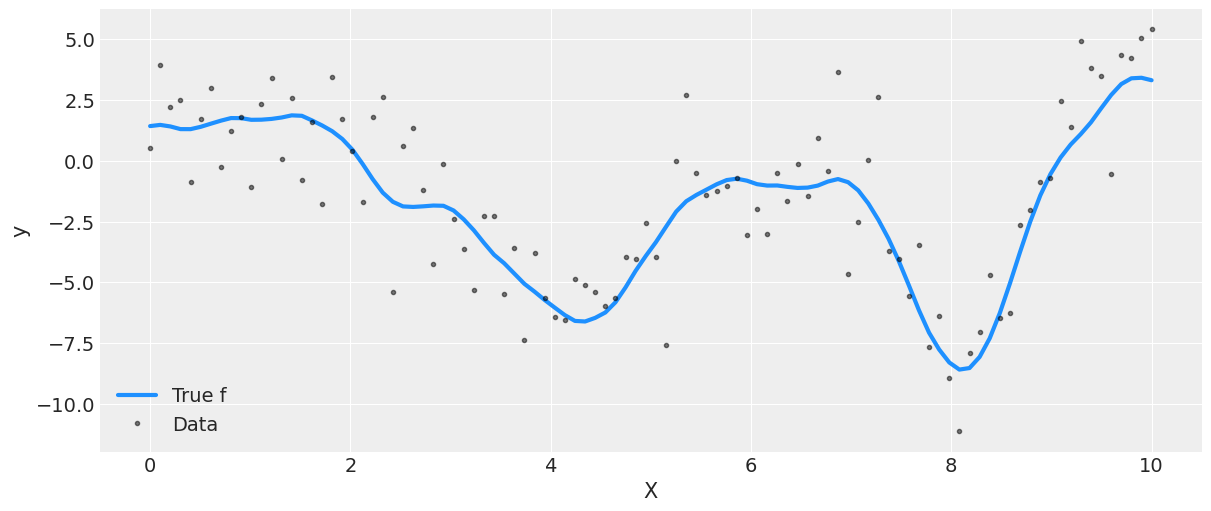

In [25]:
# set the seed
np.random.seed(1)

n_sim = 100 # The number of data points
x_sim = np.linspace(0, 10, n_sim)
X_sim = x_sim[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
l_true = 1.0
eta_true = 3.0
cov_func = eta_true**2 * pm.gp.cov.Matern52(1, l_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC built on top of PyTensor
f_true = np.random.multivariate_normal(mean_func(X_sim).eval(), 
    cov_func(X_sim).eval() + 1e-8*np.eye(n_sim), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
sigma_true = 2.0
y = f_true + sigma_true * np.random.randn(n_sim)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X_sim, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X_sim, y, 'ok', ms=3, alpha=0.5, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend();

## Marginal Likelihood Implementation

The `gp.Marginal` class in PyMC implements the simplest case of GP regression:  the observed data are the sum of a GP and Gaussian noise.  `gp.Marginal` has a `marginal_likelihood` method, a `conditional` method, and a `predict` method.  Given a mean and covariance function, the function $f(x)$ is modeled as,

$$
f(x) \sim \mathcal{GP}(m(x),\, k(x, x')) \,.
$$

The observations $y$ are the unknown function plus noise

$$
\begin{aligned}
  \epsilon &\sim N(0, \Sigma) \\
  y &= f(x) + \epsilon \\
\end{aligned}
$$

### The Marginal Likelihood

The marginal likelihood is the normalizing constant for the posterior distribution, and is the integral of the product of the likelihood and prior.

$$p(y|X) = \int_f p(y|f,X)p(f|X) df$$

where for Gaussian processes, we are marginalizing over function values $f$ (instead of parameters $\theta$).

**GP prior**:

$$\log p(f|X) = - \frac{k}{2}\log2\pi - \frac{1}{2}\log|K| -\frac{1}{2}f^TK^{-1}f $$

**Gaussian likelihood**:

$$\log p(y|f,X) = - \frac{k}{2}\log2\pi - \frac{1}{2}\log|\sigma^2I| -\frac{1}{2}(y-f)^T(\sigma^2I)^{-1}(y-f) $$

**Marginal likelihood**:

$$\log p(y|X) = \underbrace{- \frac{k}{2}\log2\pi}_{\text{constant}} \underbrace{- \frac{1}{2}\log|K + \sigma^2I|}_{\text{parameter penalty}} \underbrace{- \frac{1}{2}y^T(K+\sigma^2I)^{-1}y}_{\text{data fit}} $$

Notice that the marginal likelihood includes both a data fit term $- \frac{1}{2}y^T(K+\sigma^2I)^{-1}y$ and a parameter penalty term $\frac{1}{2}\log|K + \sigma^2I|$. Hence, the marginal likelihood can help us select an appropriate covariance function, based on its fit to the dataset at hand.

### Choosing parameters

This is relevant because we have to make choices regarding the parameters of our Gaussian process; they were chosen arbitrarily for the random functions we demonstrated above.

For example, in the squared exponential covariance function, we must choose two parameters:

$$k(x,x^{\prime}) = \theta_1\exp\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right)$$

The first parameter $\theta_1$ is a scale parameter, which allows the function to yield values outside of the unit interval. The second parameter $\theta_2$ is a length scale parameter that determines the degree of covariance between $x$ and $x^{\prime}$; smaller values will tend to smooth the function relative to larger values.

We can use the **marginal likelihood** to select appropriate values for these parameters, since it trades off model fit with model complexity. Thus, an optimization procedure can be used to select values for $\theta$ that maximize the marginial likelihood.

### Covariance functions

The behavior of individual realizations from the GP is governed by the covariance function. This function controls both the degree of *shrinkage* to the mean function and the *smoothness* of functions sampled from the GP.

PyMC includes a library of covariance functions to choose from. A flexible choice to start with is the Mat&#232;rn covariance. 

$$k_{M}(x) = \frac{\sigma^2}{\Gamma(\nu)2^{\nu-1}} \left(\frac{\sqrt{2 \nu} x}{l}\right)^{\nu} K_{\nu}\left(\frac{\sqrt{2 \nu} x}{l}\right)$$

where where $\Gamma$ is the gamma function and $K$ is a modified Bessel function. The form of covariance matrices sampled from this function is governed by three parameters, each of which controls a property of the covariance.

* **amplitude** ($\sigma$) controls the scaling of the output along the y-axis. This parameter is just a scalar multiplier, and is therefore usually left out of implementations of the Mat&#232;rn function (*i.e.* set to one)

* **lengthscale** ($l$) complements the amplitude by scaling realizations on the x-axis. Larger values make points appear closer together.

* **roughness** ($\nu$) controls the sharpness of ridges in the covariance function, which ultimately affect the roughness (smoothness) of realizations.

Though in general all the parameters are non-negative real-valued, when $\nu = p + 1/2$ for integer-valued $p$, the function can be expressed partly as a polynomial function of order $p$ and generates realizations that are $p$-times differentiable, so values $\nu \in \{3/2, 5/2\}$ are extremely common.

To provide an idea regarding the variety of forms or covariance functions, here's small selection of available ones:

In [26]:
X_grid = np.linspace(0,2,200)[:,None]

# function to display covariance matrices
def plot_cov(X, K, stationary=True):
    K = K + 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    
    with sns.axes_style("white"):

        fig = plt.figure(figsize=(14,5))
        ax1 = fig.add_subplot(121)
        m = ax1.imshow(K, cmap="inferno", 
                       interpolation='none', 
                       extent=(np.min(X), np.max(X), np.max(X), np.min(X))); 
        plt.colorbar(m);
        ax1.set_title("Covariance Matrix")
        ax1.set_xlabel("X")
        ax1.set_ylabel("X")

        ax2 = fig.add_subplot(122)
        if not stationary:
            ax2.plot(x, np.diag(K), "k", lw=2, alpha=0.8)
            ax2.set_title("The Diagonal of K")
            ax2.set_ylabel("k(x,x)")
        else:
            ax2.plot(x, K[:,0], "k", lw=2, alpha=0.8)
            ax2.set_title("K as a function of x - x'")
            ax2.set_ylabel("k(x,x')")
        ax2.set_xlabel("X")

        fig = plt.figure(figsize=(14,4))
        ax = fig.add_subplot(111)
        samples = np.random.multivariate_normal(np.zeros(200), K, 5).T;
        for i in range(samples.shape[1]):
            ax.plot(x, samples[:,i], color=cmap.inferno(i*0.2), lw=2);
        ax.set_title("Samples from GP Prior")
        ax.set_xlabel("X")

### Quadratic exponential covariance

This is the squared exponential covariance function.

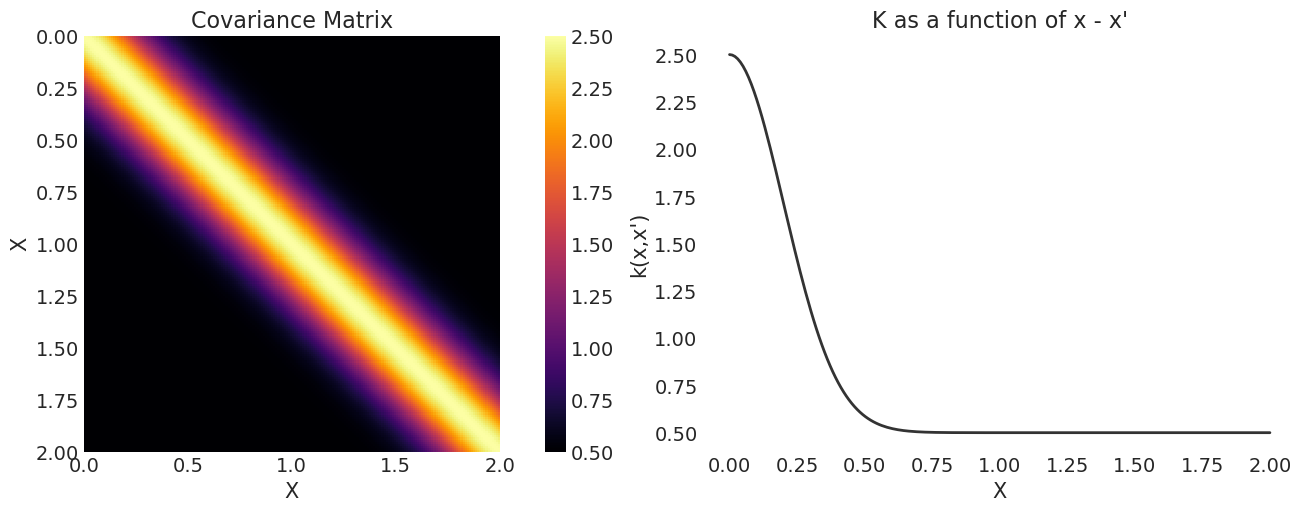

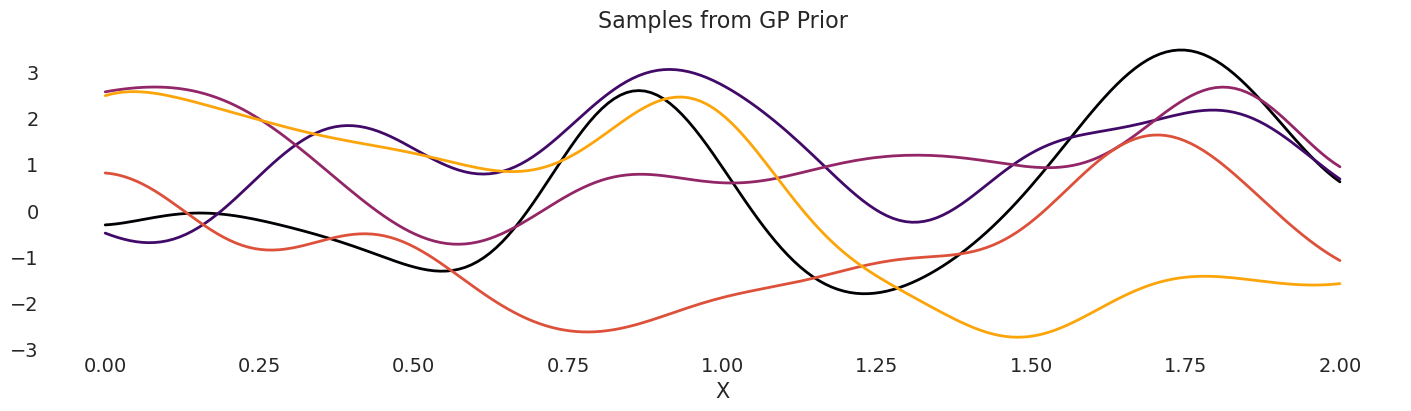

In [27]:
with pm.Model() as model:
    l = 0.2
    tau = 2.0
    b = 0.5
    cov = b + tau * pm.gp.cov.ExpQuad(1, l)

K = pytensor.function([], cov(X_grid))()

plot_cov(X_grid, K)

### Matern $\nu=3/2$ covariance

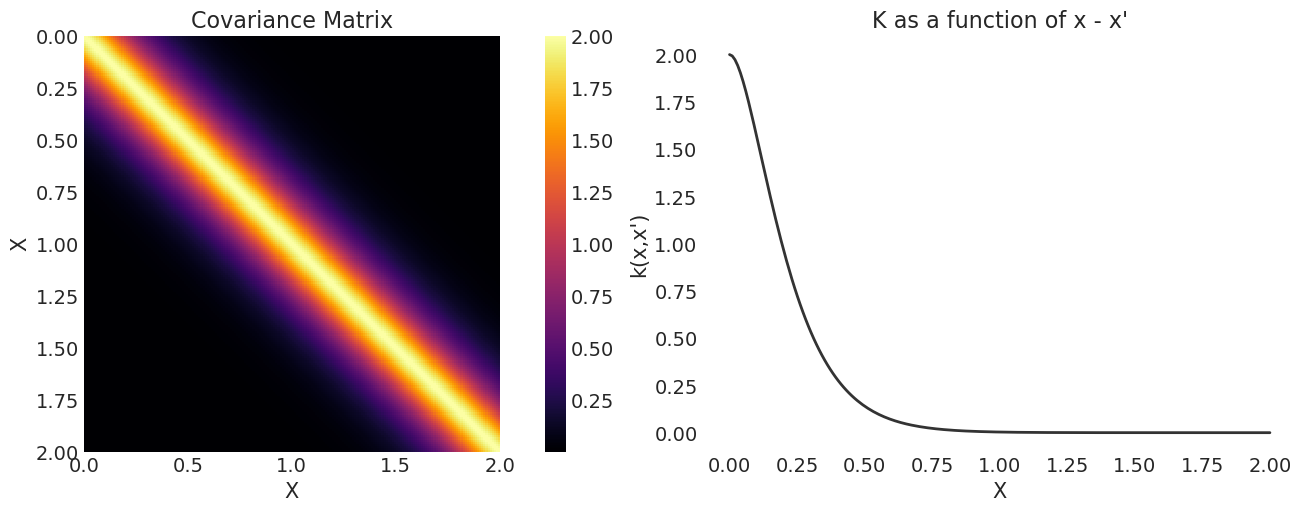

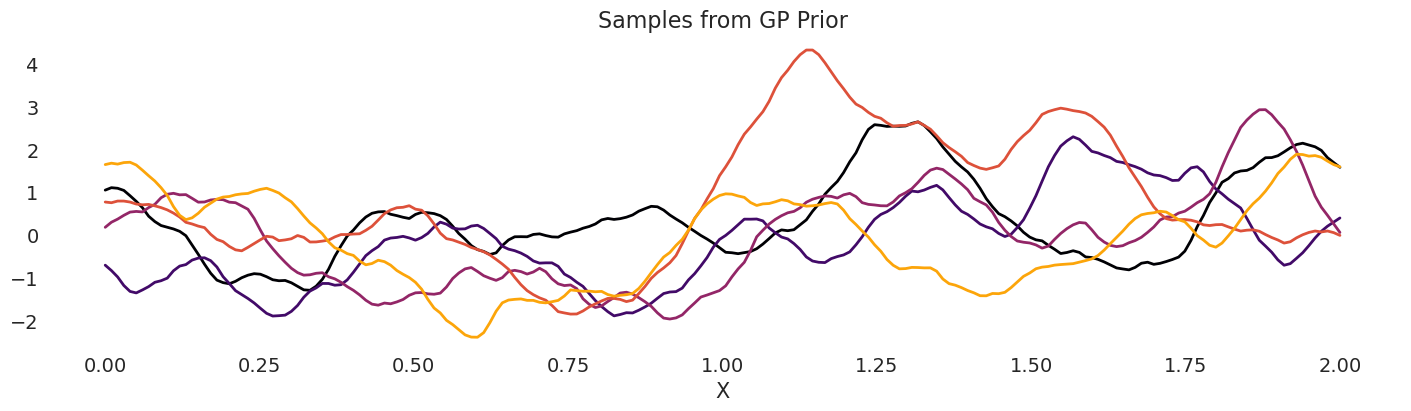

In [28]:
with pm.Model() as model:
    l = 0.2
    tau = 2.0
    cov = tau * pm.gp.cov.Matern32(1, l)

K = pytensor.function([], cov(X_grid))()

plot_cov(X_grid, K)

### Cosine covariance

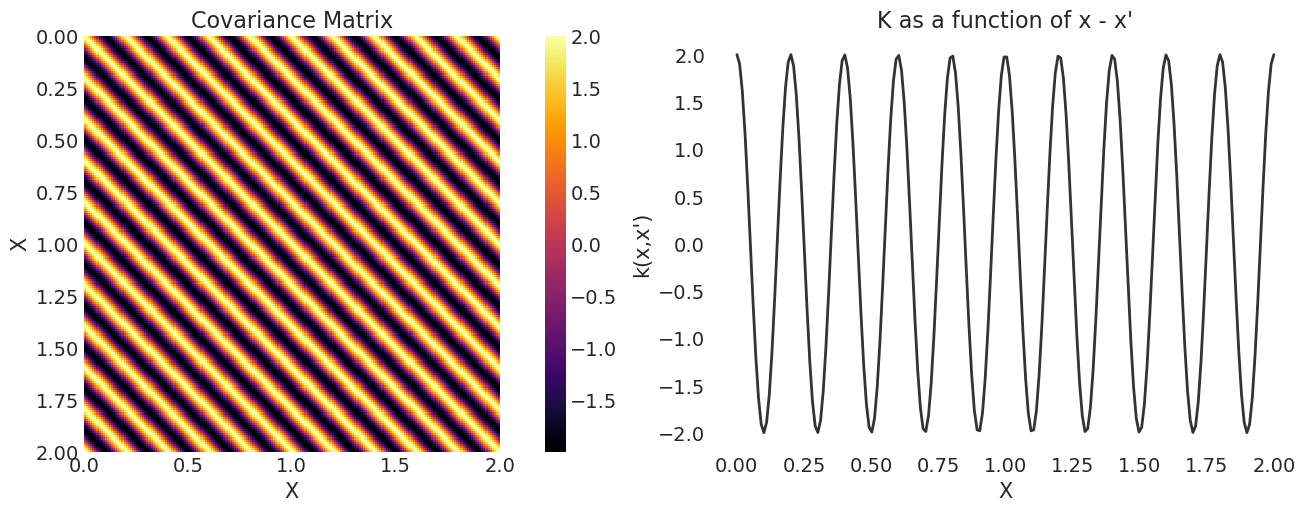

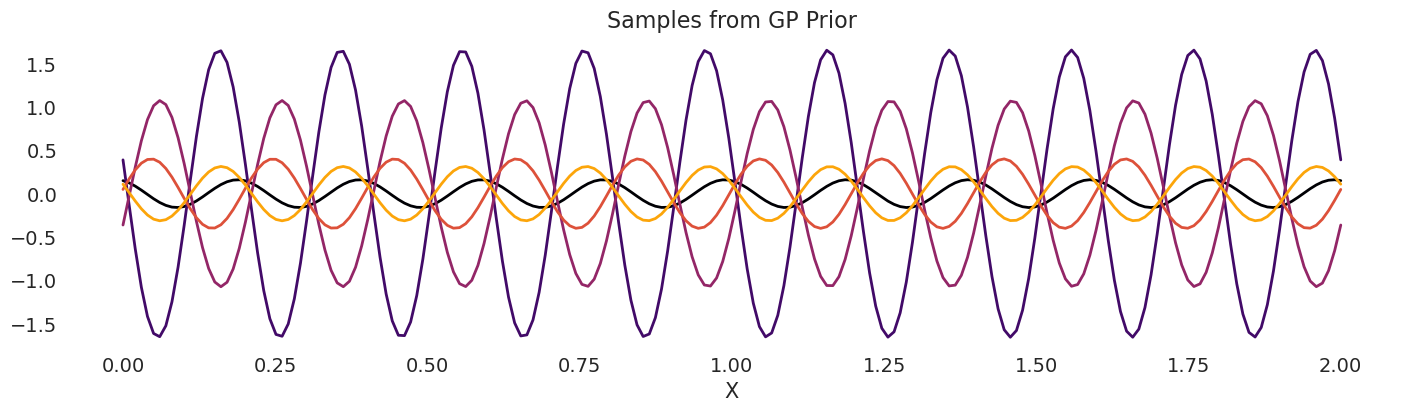

In [29]:
with pm.Model() as model:
    l = 0.2
    tau = 2.0
    cov = tau * pm.gp.cov.Cosine(1, l)

K = pytensor.function([], cov(X_grid))()

plot_cov(X_grid, K)

Now that we have a general idea about covariance functions, let's begin by defining one for our first model.

We can use a Matern(5/2) covariance to model our simulated data, and pass this as the `cov_func` argument to the `Marginal` class.

In [30]:
with pm.Model() as model:
    
    l = pm.InverseGamma("l", alpha=2, beta=1)
    eta = pm.HalfCauchy("eta", beta=5)
    
    cov = eta**2 * pm.gp.cov.Matern52(1, l)
    mean = pm.gp.mean.Constant(c=1)
    gp = pm.gp.Marginal(mean_func=mean, cov_func=cov)

### The `.marginal_likelihood` method

The unknown latent function can be analytically integrated out of the product of the GP prior probability with a normal likelihood.  This quantity is called the marginal likelihood. 

$$
p(y \mid x) = \int p(y \mid f, x) \, p(f \mid x) \, df
$$

The log of the marginal likelihood, $p(y \mid x)$, is

$$
\log p(y \mid x) = 
  -\frac{1}{2} (\mathbf{y} - \mathbf{m}_x)^{T} 
               (\mathbf{K}_{xx} + \boldsymbol\Sigma)^{-1} 
               (\mathbf{y} - \mathbf{m}_x)
  - \frac{1}{2}|\mathbf{K}_{xx} + \boldsymbol\Sigma|
  - \frac{n}{2}\log (2 \pi)
$$

$\boldsymbol\Sigma$ is the covariance matrix of the Gaussian noise.  Since the Gaussian noise doesn't need to be white to be conjugate, the `marginal_likelihood` method supports either using a white noise term when a scalar is provided, or a noise covariance function when a covariance function is provided.

The `gp.marginal_likelihood` method implements the quantity given above.

In [31]:
with model:
    
    sigma = pm.HalfCauchy("sigma", beta=5)
    obs = gp.marginal_likelihood("obs", X=X_sim, y=y, sigma=sigma)
    

In [32]:
with model:
    marginal_post = pm.sample(500, tune=1000, chains=2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [l, eta, sigma]


Output()

Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Let's have a look at the posterior estimates of the hyperparameters.

In [33]:
summary = az.summary(marginal_post, var_names=["l", "eta", "sigma"], round_to=2, kind="stats")
summary["True value"] = [l_true, eta_true, sigma_true]
summary

mean    sd  hdi_3%  hdi_97%  True value
l      1.12  0.27    0.69     1.66         1.0
eta    4.26  1.17    2.48     6.29         3.0
sigma  1.94  0.15    1.68     2.23         2.0

### The `.conditional` distribution

In addition to fitting the model, we would like to be able to generate predictions. This implies sampling from the posterior predictive distribution, which if you recall is just some linear algebra:

$$\begin{aligned}
m^*(x^*) &= k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}y \\
k^*(x^*) &= k(x^*,x^*)+\sigma^2 - k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}k(x^*,x)
\end{aligned}$$

PyMC allows for predictive sampling after the model is fit, using the recorded values of the model parameters to generate samples. The `conditional` method implements the predictive GP above, called with a grid of points over which to generate realizations:

The `.conditional` has an optional flag for `pred_noise`, which defaults to `False`.  When `pred_noise=False`, the `conditional` method produces the predictive distribution for the underlying function represented by the GP.  When `pred_noise=True`, the `conditional` method produces the predictive distribution for the GP plus noise.  

If using an additive GP model, the conditional distribution for individual components can be constructed by setting the optional argument `given`.  

We can define a grid of new values from `x=0` to `x=20`, then add the GP conditional to the model, given the new X values:



In [34]:
X_new = np.linspace(0, 20, 600)[:,None]

with model:
    f_pred = gp.conditional("f_pred", X_new)

We can draw samples from the posterior predictive distribution over the specified grid of values.

In [35]:
with model:
    pred_samples = pm.sample_posterior_predictive(
        marginal_post.sel(draw=slice(0, 20)), var_names=['f_pred']
    )

Sampling: [f_pred]


Output()

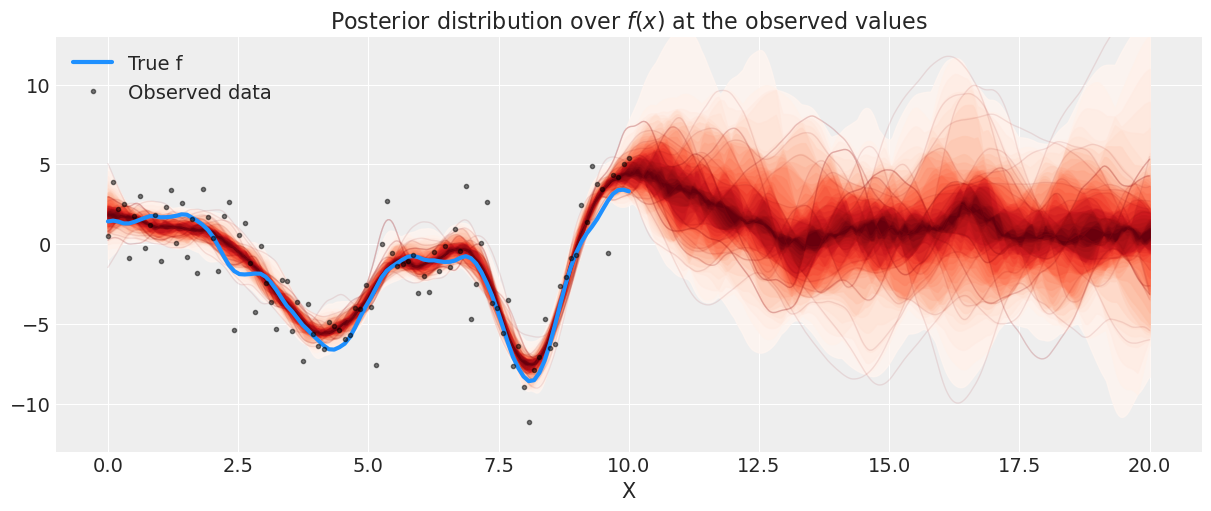

In [36]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist
f_pred_samples = az.extract(pred_samples, group="posterior_predictive", var_names=["f_pred"])
plot_gp_dist(ax, samples=f_pred_samples.T, x=X_new);

# plot the data and the true latent function
plt.plot(x_sim, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(x_sim, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylim([-13,13]);
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

The prediction also matches the results from `gp.Latent` very closely.  What about predicting new data points?  Here we only predicted $f_*$, not $f_*$ + noise, which is what we actually observe.

The `conditional` method of `gp.Marginal` contains the flag `pred_noise` whose default value is `False`.  To draw from the *posterior predictive* distribution, we simply set this flag to `True`. 

In [37]:
with model:
    y_pred = gp.conditional("y_pred", X_new, pred_noise=True)
    y_samples = pm.sample_posterior_predictive(
        marginal_post.sel(draw=slice(0, 20)), var_names=['y_pred']
    )

Sampling: [y_pred]


Output()

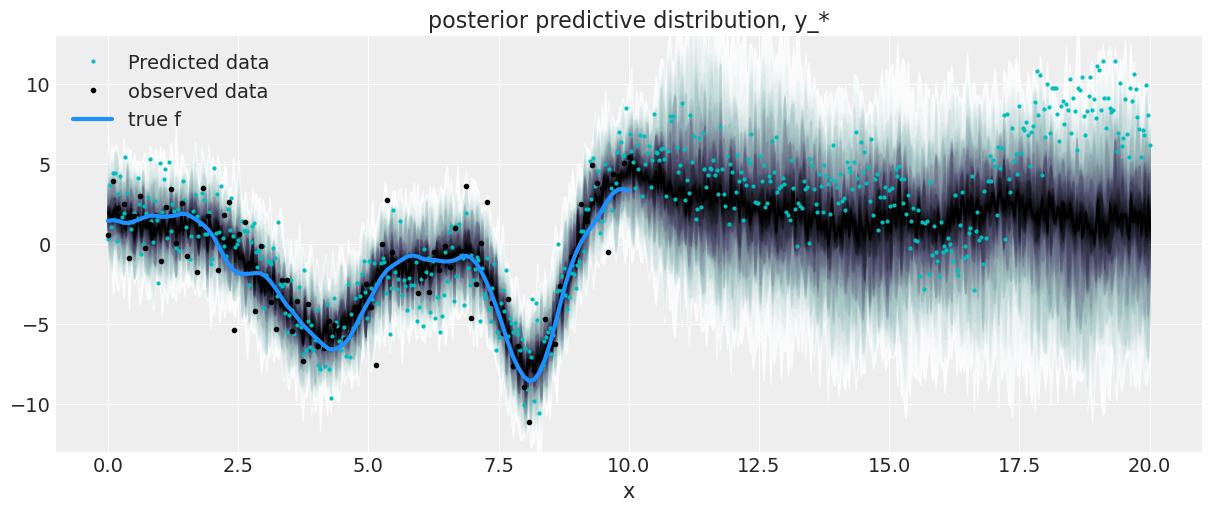

In [38]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# posterior predictive distribution
y_pred_samples = az.extract(y_samples, group="posterior_predictive", var_names=["y_pred"])
plot_gp_dist(ax, y_pred_samples.T, X_new, plot_samples=False, palette="bone_r");

# overlay a scatter of one draw of random points from the 
#   posterior predictive distribution
plt.plot(X_new, y_pred_samples.values.T[1], "co", ms=2, label="Predicted data");

# plot original data and true function
plt.plot(X_sim, y, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X_sim, f_true, "dodgerblue", lw=3, label="true f");

plt.xlabel("x"); plt.ylim([-13,13]);
plt.title("posterior predictive distribution, y_*"); plt.legend();

### Real-world example: Snowshoe hare population dynamics

Let's apply Gaussian processes to a real ecological problem. The plot below shows the relationship between the date and the number of snowshoe hares observed in Kluane, Yukon, Canada. This data comes from long-term monitoring studies of the hare population cycles in the boreal forest ecosystem.

Snowshoe hares are known for their dramatic population cycles, typically occurring every 8-11 years. These cycles are driven by complex predator-prey dynamics, particularly with lynx, as well as food availability and other environmental factors. The non-linear nature of these population dynamics makes them an excellent candidate for Gaussian process modeling.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7a/Lepus_americanus_5459_cropped.jpg/640px-Lepus_americanus_5459_cropped.jpg)

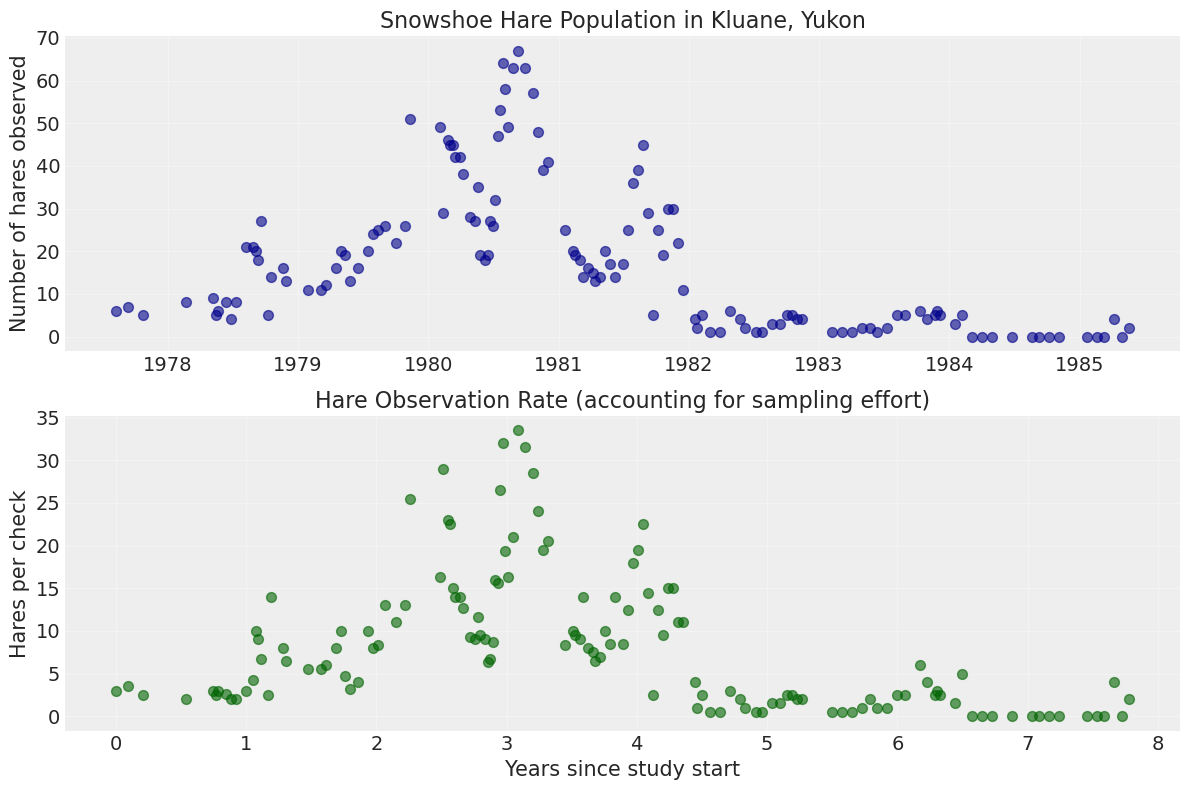

In [39]:
# Load the hare population data
hare_data = pd.read_csv('../data/hare-data-kluane.csv', parse_dates=['date'])

# Convert date to numeric time for GP modeling
hare_data['time'] = (hare_data['date'] - hare_data['date'].min()).dt.days / 365.25  # Years since start

# Create a rate variable (hares per check) to account for sampling effort
hare_data['hare_rate'] = hare_data['# Indiv'] / hare_data['# Checks'].replace(0, 1)  # Avoid division by zero

# Plot the raw data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.scatter(hare_data['date'], hare_data['# Indiv'], s=50, alpha=0.6, c='darkblue')
ax1.set_ylabel('Number of hares observed')
ax1.set_title('Snowshoe Hare Population in Kluane, Yukon')
ax1.grid(True, alpha=0.3)

ax2.scatter(hare_data['time'], hare_data['hare_rate'], s=50, alpha=0.6, c='darkgreen')
ax2.set_xlabel('Years since study start')
ax2.set_ylabel('Hares per check')
ax2.set_title('Hare Observation Rate (accounting for sampling effort)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()

In [40]:
# Remove rows with zero checks (no sampling effort)
hare_data_clean = hare_data[hare_data['# Checks'] > 0].copy()

with pm.Model() as hare_model:

    # GP hyperparameters
    # Lengthscale prior - we expect cycles of 8-11 years based on ecological knowledge
    lengthscale = pm.LogNormal('lengthscale', mu=np.log(3), sigma=0.5)
    
    # Amplitude prior - controls the magnitude of population fluctuations
    amplitude = pm.LogNormal('amplitude', mu=np.log(10), sigma=1)
    
    # Mean function - we'll use a constant mean representing the average hare rate
    M = pm.gp.mean.Constant(c=hare_data_clean.hare_rate.mean())
    
    # Matern 5/2 covariance function - good for capturing smooth but not infinitely differentiable processes
    K = (amplitude**2) * pm.gp.cov.Matern52(1, lengthscale) 
    
    # Observation noise
    sigma = pm.HalfNormal('sigma', sigma=5)
    
    # Define the GP
    hare_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    
    # Likelihood - modeling the hare rate
    hare_gp.marginal_likelihood('hare_rate', 
                                X=hare_data_clean.time.values.reshape(-1,1), 
                                y=hare_data_clean.hare_rate.values, 
                                sigma=sigma)

In [41]:
with hare_model:
    hare_trace = pm.sample(1000, tune=1000, chains=2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lengthscale, amplitude, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


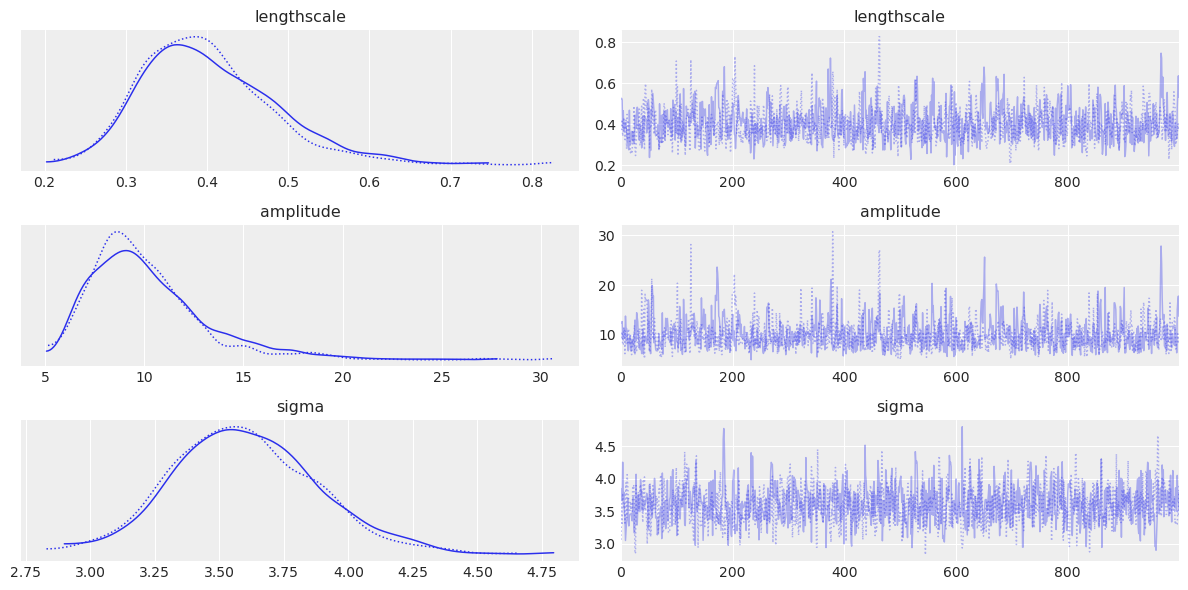

In [42]:
az.plot_trace(hare_trace, var_names=['lengthscale', 'amplitude', 'sigma'])
plt.tight_layout();

In [43]:
# Create prediction grid - extend slightly beyond observed data to show extrapolation
time_pred = np.linspace(hare_data_clean.time.min() - 0.5, 
                        hare_data_clean.time.max() + 0.5, 200).reshape(-1, 1)

with hare_model:
    hare_pred = hare_gp.conditional("hare_pred", time_pred)
    hare_samples = pm.sample_posterior_predictive(
        hare_trace.sel(draw=slice(0, 50)), 
        var_names=["hare_pred"]
    )

Sampling: [hare_pred]


Output()

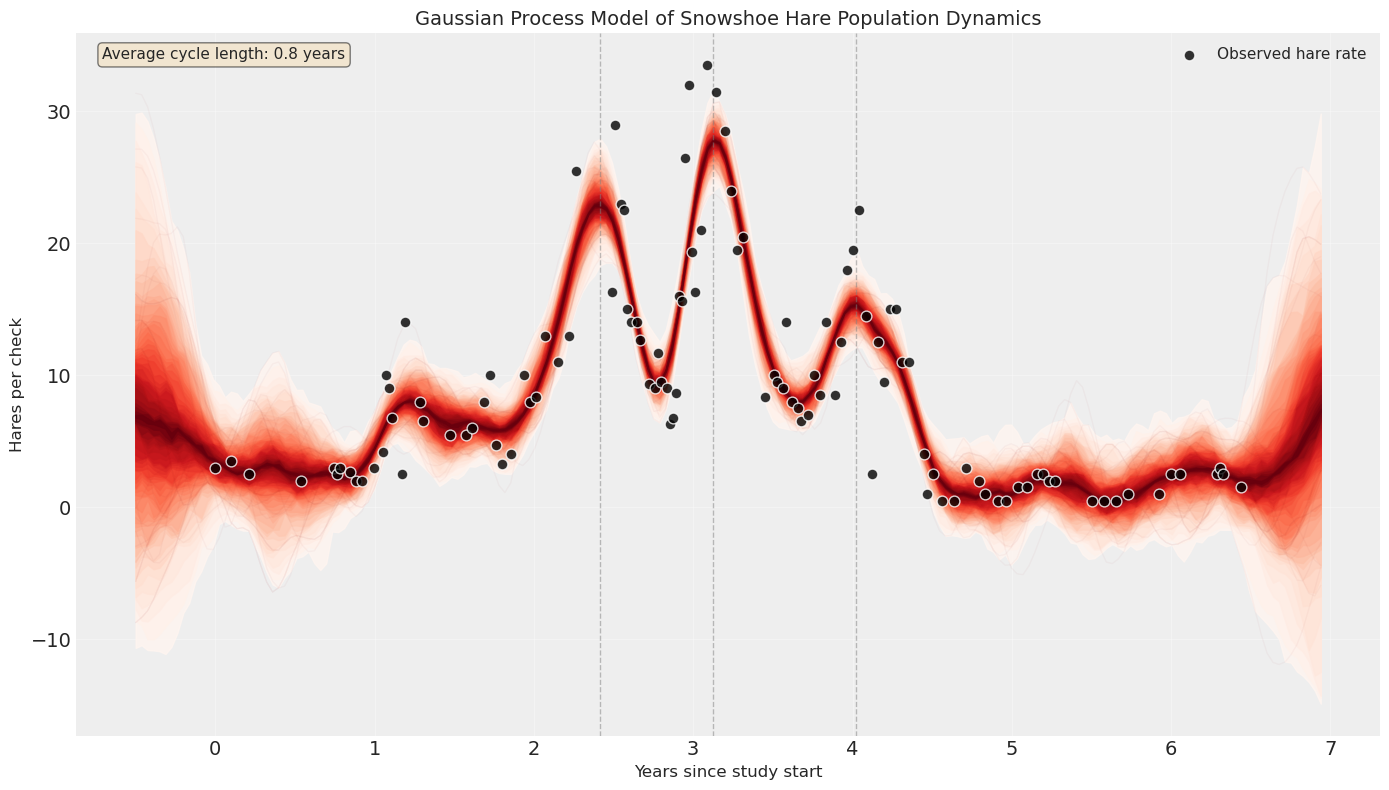

In [44]:
# Create a figure with posterior predictions
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Plot posterior samples
f_pred_samples = az.extract(hare_samples, group="posterior_predictive", var_names=["hare_pred"])
plot_gp_dist(ax, f_pred_samples.T, time_pred, palette="Reds", fill_alpha=0.8, samples_alpha=0.03)

# Plot observed data
ax.scatter(hare_data_clean['time'], hare_data_clean['hare_rate'], 
           c='black', s=60, alpha=0.8, zorder=10, edgecolors='white', linewidth=1,
           label='Observed hare rate')

# Add labels and formatting
ax.set_xlabel('Years since study start', fontsize=12)
ax.set_ylabel('Hares per check', fontsize=12)
ax.set_title('Gaussian Process Model of Snowshoe Hare Population Dynamics', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

# Add vertical lines to show the cyclic pattern
posterior_mean = f_pred_samples.mean(dim='sample').values
peaks, _ = sp.signal.find_peaks(posterior_mean, prominence=5)
if len(peaks) > 1:
    for peak in peaks:
        ax.axvline(time_pred[peak, 0], color='gray', linestyle='--', alpha=0.5, linewidth=1)
    
    # Calculate average cycle length
    if len(peaks) > 1:
        cycle_lengths = np.diff(time_pred[peaks, 0])
        avg_cycle = np.mean(cycle_lengths)
        ax.text(0.02, 0.98, f'Average cycle length: {avg_cycle:.1f} years', 
                transform=ax.transAxes, fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()

The Gaussian process model successfully captures the cyclic nature of the snowshoe hare population. A few observations:

1. **Lengthscale**: The posterior distribution suggests a lengthscale parameter that aligns well with the known 8-11 year population cycles of snowshoe hares in the boreal forest.

2. **Amplitude**: The model captures the dramatic population fluctuations, from near-extinction levels to population booms.

3. **Uncertainty quantification**: The GP provides natural uncertainty quantification, with wider credible intervals where data is sparse or at the boundaries of our observations.

4. **Smoothness**: The Matérn 5/2 kernel provides an appropriate level of smoothness for biological population data - smooth enough to capture the overall trend but flexible enough to handle the relatively rapid changes during population crashes and recoveries.

This example demonstrates how marginal GPs can effectively model complex ecological time series with non-linear dynamics and provide principled uncertainty estimates for both interpolation and short-term extrapolation.

### Using `.predict`

We can use the `.predict` method to return the mean and variance given a particular `point`.  Since we used `find_MAP` in this example, `predict` returns the same mean and covariance that the distribution of `.conditional` has.  

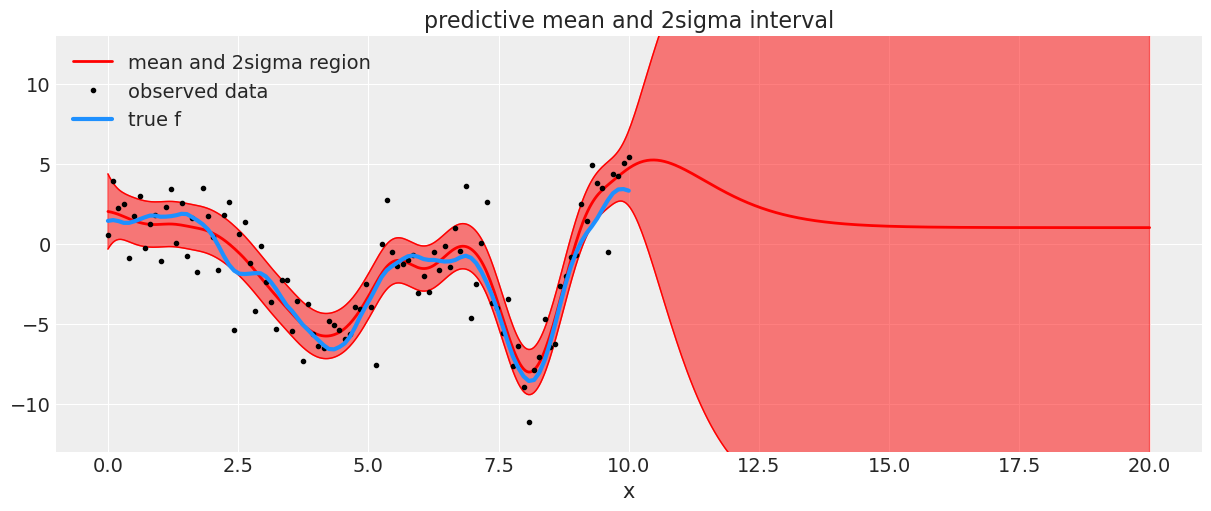

In [45]:
# predict
X_new = np.linspace(0, 20, 600)[:,None]

with model:
    mu, var = gp.predict(X_new, point=az.extract(marginal_post.posterior.sel(draw=[0], chain=[0])).squeeze(), diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2sigma intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 2sigma region");
plt.plot(X_new, mu + 2*sd, 'r', lw=1); plt.plot(X_new, mu - 2*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X_sim, y, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X_sim, f_true, "dodgerblue", lw=3, label="true f");

plt.xlabel("x"); plt.ylim([-13,13]);
plt.title("predictive mean and 2sigma interval"); plt.legend();

## Latent Variable Implementation

The `gp.Latent` class is a more general implementation of a GP.  It is called "Latent" because the underlying function values are treated as latent variables.  It has a `prior` method, and a `conditional` method.  Given a mean and covariance function, the function $f(x)$ is modeled as,

$$
f(x) \sim \mathcal{GP}(m(x),\, k(x, x')) \,.
$$

## `.prior`

With some data set of finite size, the `prior` method places a multivariate normal prior distribution on the vector of function values, $\mathbf{f}$,

$$
\mathbf{f} \sim \text{MvNormal}(\mathbf{m}_{x},\, \mathbf{K}_{xx}) \,,
$$

where the vector $\mathbf{m}$ and the matrix $\mathbf{K}_{xx}$ are the mean vector and covariance matrix evaluated over the inputs $x$.  

By default, PyMC reparameterizes the prior on `f` under the hood by rotating it with the Cholesky factor of its covariance matrix.  This helps to reduce covariances in the posterior of the transformed random variable, `v`.  The reparameterized model is,

$$
\begin{aligned}
  \mathbf{v} \sim \text{N}(0, 1)& \\
  \mathbf{L} = \text{Cholesky}(\mathbf{K}_{xx})& \\
  \mathbf{f} = \mathbf{m}_{x} + \mathbf{Lv} \\
\end{aligned}
$$

This reparameterization can be disabled by setting the optional flag in the `prior` method, `reparameterize = False`.  The default is `True`.

## Poisson regession

Let's revisit the hare data. Since we're dealing with count data (number of hares observed), a Poisson likelihood is more appropriate than the normal likelihood used in the marginal GP implementation.

We'll model the hare count data using a latent Gaussian process with a Poisson likelihood. The latent GP represents the underlying log-intensity of the Poisson process.

Here's the model in PyMC.  We use a $\text{Gamma}(2, 1)$ prior over the lengthscale parameter, and weakly informative $\text{HalfCauchy}(2)$ priors over the covariance function scale, and noise scale.  A $\text{Gamma}(2, 0.1)$ prior is assigned to the degrees of freedom parameter of the noise.  Finally, a GP prior is placed on the unknown function.  

In [ ]:
X_hare = hare_data_clean['time'].values[:, None]
y_hare = hare_data_clean['# Indiv'].values

with pm.Model() as hare_poisson_model:

    lengthscale = pm.InverseGamma('lengthscale', alpha=2, beta=1)
    amplitude = pm.HalfNormal('amplitude', sigma=10)
    
    cov = (amplitude**2) * pm.gp.cov.Matern52(1, lengthscale)
    
    gp = pm.gp.Latent(cov_func=cov)
    
    f = gp.prior('f', X=X_hare)
    
    pm.Poisson('y_obs', mu=pm.math.exp(f), observed=y_hare)
    
    hare_poisson_trace = pm.sample(draws=1000, tune=500, nuts_sampler='nutpie', chains=1)

Notice that I snuck in a new argument to `sample`:

`nuts_sampler='nutpie'`

While the latent variable implementation makes Gaussian processes really flexible, it also comes with a computational cost since we are no longer able to work witht the marginal likelihood directly. So, its nice to be able to take advantage of some of the accelerated sampling methods available in PyMC.

> ### Accelerated Sampling in PyMC with Numba and Jax
> 
> By default, PyMC is using the C backend to compile its models, which then gets 
> called by the Python-based samplers. PyMC also offers accelerated sampling 
> through the use of Numba and Jax via the Numpyro and Nutpie libraries. 
> These libraries provide just-in-time (JIT) compilation and GPU acceleration, 
> which can significantly speed up the sampling process.
> 
> **Numba** is a JIT compiler that translates a subset of Python and NumPy code 
> into fast machine code. It can be used to accelerate the execution of PyMC models by 
> compiling the log-probability function.
> 
> **Jax** is a library for high-performance numerical computing that provides 
> automatic differentiation and GPU acceleration. It can be used with PyMC to speed up 
> the sampling process by leveraging Jax's capabilities.
> 
> **Numpyro** is a probabilistic programming library built on Jax. It provides 
> a high-level interface for defining and sampling from probabilistic models. PyMC can 
> use Numpyro as a backend to take advantage of Jax's acceleration.
> 
> **Nutpie** is a library that provides an optimized implementation of the 
> No-U-Turn Sampler (NUTS) algorithm. It can be used with PyMC to perform efficient 
> sampling.
> 
> To use these libraries with PyMC, you can specify the `nuts_sampler` argument in the `pm.sample` function, using either `"nutpie"` or `"numpyro"`.



Below are the posteriors of the covariance function hyperparameters. 

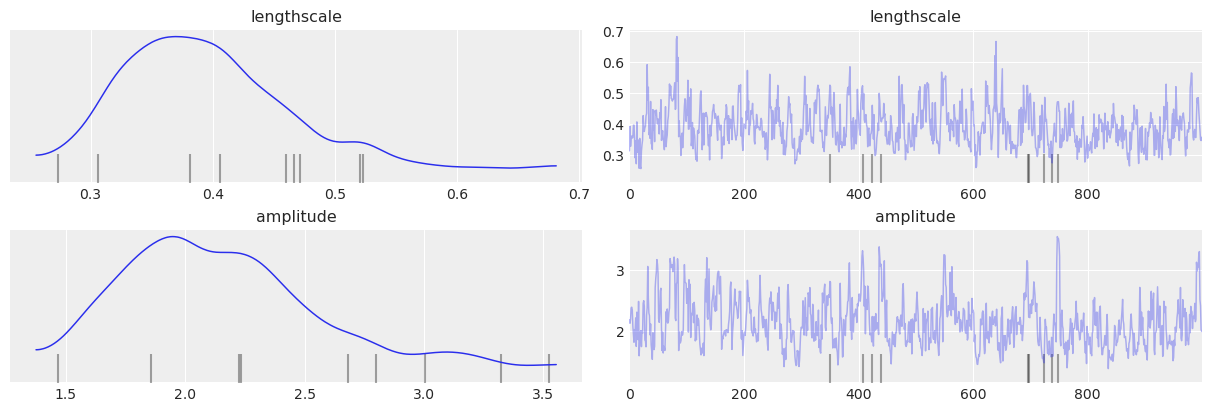

In [ ]:
az.plot_trace(hare_poisson_trace, var_names=['lengthscale', 'amplitude'], backend_kwargs=dict(constrained_layout=True));

In [ ]:
time_pred = np.linspace(hare_data_clean.time.min() - 0.5, 
                        hare_data_clean.time.max() + 0.5, 200)[:, None]

with hare_poisson_model:

    f_pred = gp.conditional('f_pred', time_pred)
    
    lambda_pred = pm.Deterministic('lambda_pred', pm.math.exp(f_pred))
    
    hare_pred_samples = pm.sample_posterior_predictive(
        hare_poisson_trace.sel(draw=slice(0, 50)), 
        var_names=['f_pred', 'lambda_pred']
    )

Sampling: [f_pred]


Output()

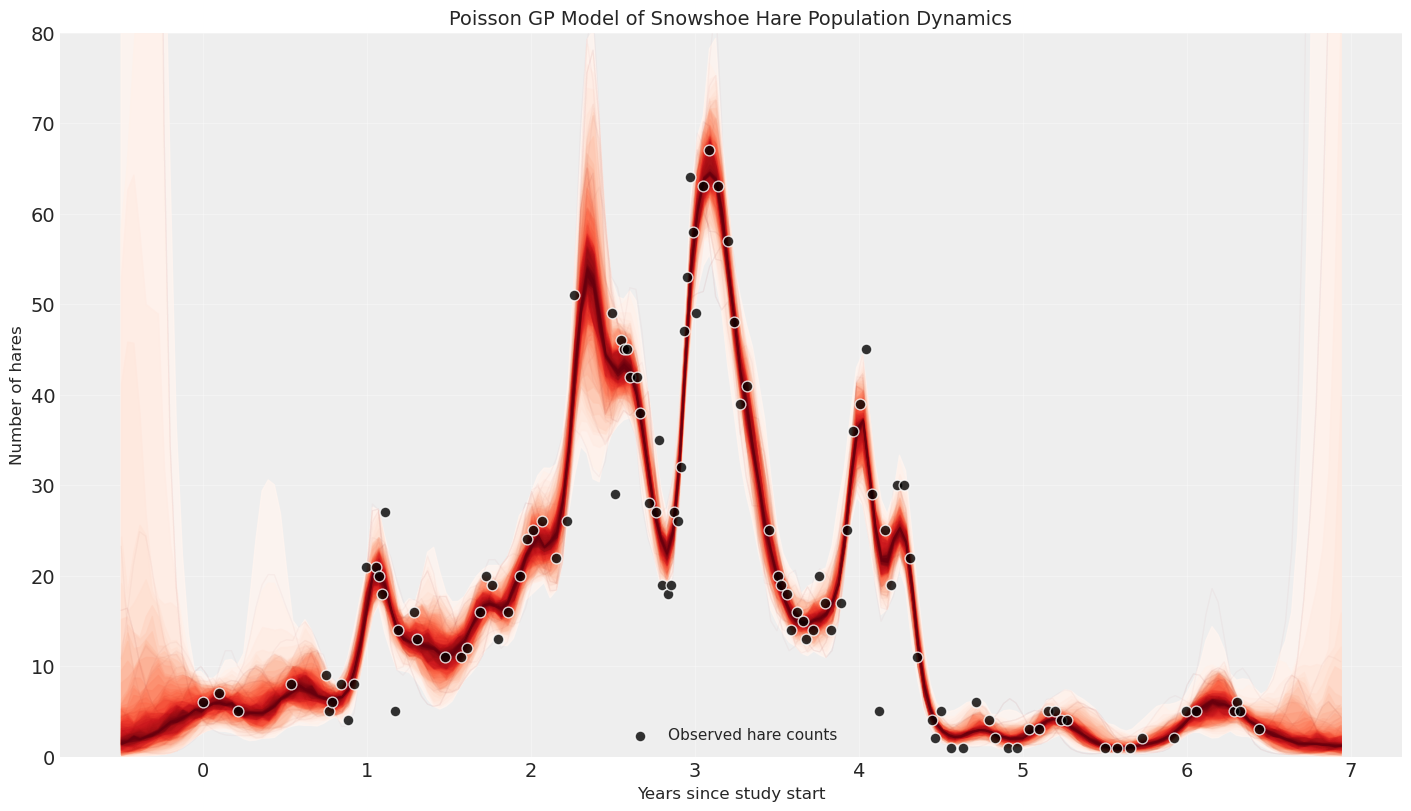

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

lambda_pred_samples = az.extract(hare_pred_samples, group="posterior_predictive", var_names=["lambda_pred"])

max_observed = np.max(y_hare)
y_max = min(max_observed * 1.5, np.percentile(lambda_pred_samples.values, 95))

plot_gp_dist(ax, lambda_pred_samples.T, time_pred, 
             palette="Reds", fill_alpha=0.8, samples_alpha=0.03)

ax.scatter(hare_data_clean['time'], y_hare, 
          c='black', s=60, alpha=0.8, zorder=10, edgecolors='white', linewidth=1,
          label='Observed hare counts')

ax.set_xlabel('Years since study start', fontsize=12)
ax.set_ylabel('Number of hares', fontsize=12)
ax.set_title('Poisson GP Model of Snowshoe Hare Population Dynamics', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

ax.set_ylim(0, 80);

The latent variable implementation is more computationally intensive than the marginal GP approach but offers much greater flexibility in terms of likelihood choices, making it ideal for non-Gaussian data like counts, binary outcomes, or other exponential family distributions.

## Faster GPs: Hilbert Space Approximate Gaussian Processes (HSGP)

The Hilbert Space Gaussian processes approximation is a **low-rank GP approximation** that is particularly well-suited to usage in probabilistic programming languages.  It approximates the GP using a pre-computed and fixed set of basis functions that don't depend on the form of the covariance kernel or its hyperparameters.  It's a _parametric_ approximation, so prediction can be done as one would with any other type of Bayesian model in PyMC;  You don't need to define the `.conditional` distribution that the `Marginal` and `Latent` GPs rely on.  This makes it _much_ easier to integrate an HSGP into your existing model as they can be used anywhere within a model and with any likelihood function.  

It's also fast! 🏃 The computational cost for standard GPs per MCMC step is $\mathcal{O}(n^3)$, where $n$ is the number of data points.  For HSGPs, it is $\mathcal{O}(mn + m)$, where $m$ is the number of basis vectors. 

The HSGP approximation does carry some caveats:
1. It can only be used with _stationary_ covariance kernels such as the Matern family.  The `HSGP` class is compatible with any `Covariance` class that implements the `power_spectral_density` method.  There is a special case made for the `Periodic` covariance, which is implemented in PyMC by `HSGPPeriodic`. 
2. It does not scale well with the input dimension.  The HSGP approximation is a good choice if your GP is over a one dimensional process like a time series, or a two dimensional spatial point process.  It's likely not an efficient choice where the input dimension is larger than three. 
3. It _may_ struggle with more rapidly varying processes.  If the process you're trying to model changes very quickly relative to the extent of the domain, the HSGP approximation may fail to accurately represent it.  We'll show in later sections how to set the accuracy of the approximation, which involves a trade-off between the fidelity of the approximation and the computational complexity.
4. For smaller data sets, the full unapproximated GP may still be more efficient.

A secondary goal of this implementation is **flexibility** via an accessible implementation where the core computations are implemented in a modular way. This results in both a "high-level" interface where users can use the familiar `.prior` and `.conditional` methods and essentially treat the HSGP class as a drop in replacement for `pm.gp.Latent`, and a "low-level" interface that exposes the HSGP as a parametric model.  For more complex models with multiple HSGPs, users can work directly with functions like `pm.gp.hsgp_approx.calc_eigenvalues` and `pm.gp.hsgp_approx.calc_eigenvectors`.

### How does it work?

In HSGP, the covariance function is viewed as a mathematical operator acting on a high-dimensional space (Hilbert space). We represent covariance function as a series expansion of eigenvalues and eigenfunctions of the Laplace operator. These eigenfunctions capture the smoothness properties of the underlying function being modeled in the form of a set of basis functions.

$$
f \sim \mathcal{G P}\left(0, k\left(x, x^{\prime} ; \ell\right)\right) \longrightarrow f \approx \phi(x) \beta(\ell)
$$

where the basis functions $\phi$ only depend on the input and the coefficients $\beta$ only depend on the kernel hyperparmeters.

By approximating the covariance function with a set of basis functions, HSGP reduces the complexity significantly, from $\mathcal{O}(n^3)$ to $\mathcal{O}(nm + m)$. 


#### Cherry blossom data set

The cherry blossom dataset contains historical records of cherry tree blooming in Japan dating back to 801 CE. It includes:

- `year`: The year of observation (801-2015)
- `doy`: Day of year when cherry trees first bloomed (measured in days)
- `temp`: Reconstructed temperature data (in Celsius)
- `temp_upper` and `temp_lower`: Upper and lower bounds of temperature estimates

The dataset shows considerable annual variation in bloom timing, and is valuable for studying climate patterns and phenological responses over an exceptionally long time period, making it useful for Gaussian Process modeling and other time series analyses.

In [67]:
df = pd.read_csv(pm.get_data("../data/cherry_blossoms.csv"), sep=";")
df = df[["year", "doy", "temp"]].dropna()

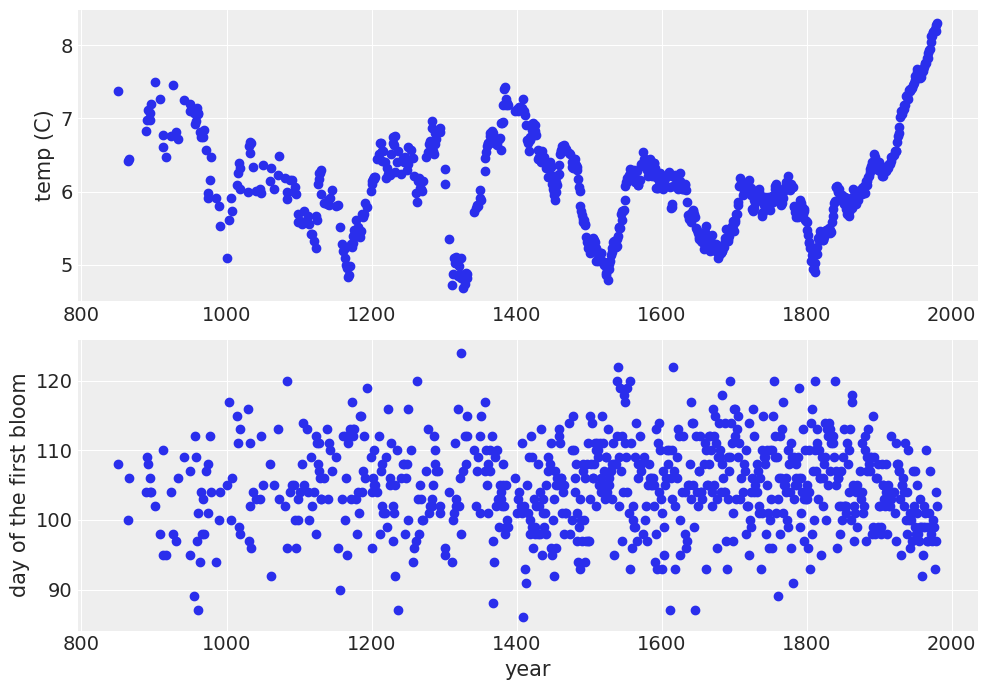

In [68]:
fig, axs = plt.subplots(2, 1, figsize=(10, 7)); axs = axs.flatten()

axs[0].scatter(df["year"], df["temp"])
axs[1].scatter(df["year"], df["doy"])

axs[1].set_xlabel("year")
axs[0].set_ylabel("temp (C)")
axs[1].set_ylabel("day of the first bloom")
fig.tight_layout()

The first step is the same as with any other GP model: we need to specify a covariance function. We will use the Matern 5/2 covariance function, which is a good default choice for many problems.

In [69]:
coords = {
    "year": df.year.tolist()
}
with pm.Model(coords=coords) as cherry_blossom_model:
    # Set prior on GP hyperparameters
    eta = pm.Exponential("eta", lam=0.25)

    ell = pm.InverseGamma('ell', 10, 500)
    
    cov = eta**2 * pm.gp.cov.Matern52(1, ls=ell)

The next step is to specify the HSGP model. We will use the `HSGP` class, which is a drop-in replacement for the `gp.Latent` class. 

There are three important hyperparameters for `HSGP`:

- `m`: The **number of basis vectors** to use for each active dimension.
- `L`: The **boundary of the space** for each active_dim. It is called the boundary condition. Choose `L` such that the domain `[-L, L]` contains all points in the column of `X` given by the active dimension.
- `c`: The **proportion extension factor**. Used to construct `L` from `X`. Defined as $S = \max|X| \ni X \in [-S, S]$. L is calculated as `c * S`. One of `c` or `L` must be provided. 

# Choosing the HSGP approximation parameters

Before fitting a model with an HSGP, you have to choose `m` and `c` or `L`.  `m` is the number of basis vectors.  Recall that the computational complexity of the HSGP approximation is $\mathcal{O}(mn + m)$, where $n$ is the number of data points. 

This choice is a balance between three concerns:
1.  The accuracy of the approximation.
2.  Reducing the computational burden.
3.  The `X` locations where predictions or forecasts will need to be made.

The best way to understand how to choose these parameters is to understand how `m`, `c` and `L` relate to each other, which requires understanding a bit more about how the approximation works under the hood.  

### How `L` and `c` affect the basis

The HSGP approximates the GP prior as a **linear combination of sinusoids**.  The coefficients of the linear combination are IID normal random variables whose standard deviation depends on GP hyperparameters (which are an amplitude and lengthscale for the Matern family). 

To see this, we'll make a few plots of the $m=3$ basis vectors and pay careful attention to how they behave at the boundaries of the domain.  Note that we have to center the `x` data first, and then choose `L` in relation to the centered data.  It's worth mentioning here that the basis vectors we're plotting do not depend on either the choice of the covariance kernel or on any unknown parameters the covariance function has.    

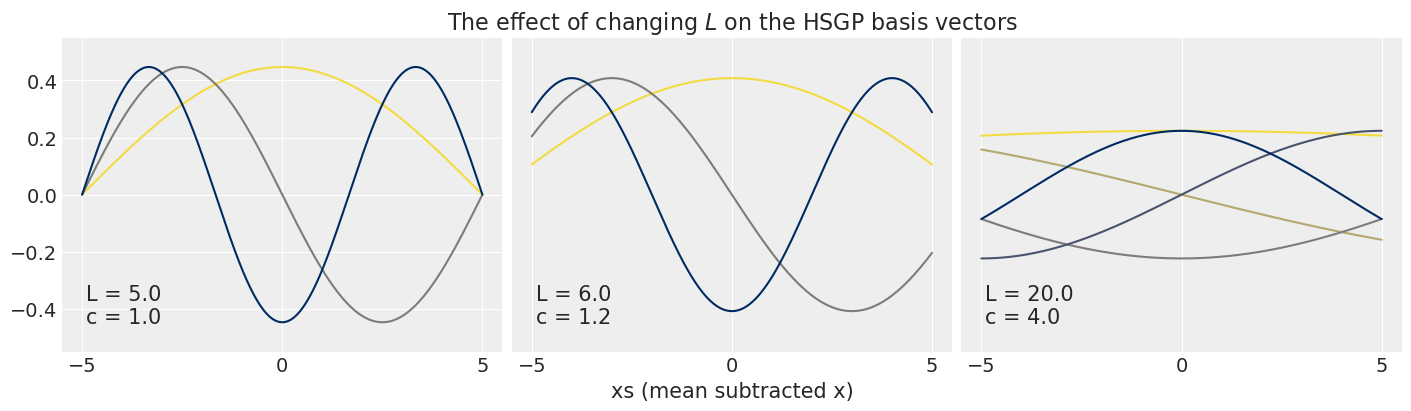

In [70]:
# Our data goes from x=-5 to x=5
x = np.linspace(-5, 5, 1000)

# (plotting code)
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
plt.subplots_adjust(wspace=0.02)
ylim = 0.55
axs[0].set_ylim([-ylim, ylim])
axs[1].set_yticks([])
axs[1].set_ylim([-ylim, ylim])
axs[1].set_xlabel("xs (mean subtracted x)")
axs[1].set_title("The effect of changing $L$ on the HSGP basis vectors")
axs[2].set_yticks([])
axs[2].set_ylim([-ylim, ylim])

# change L as we create the basis vectors
L_options = [5.0, 6.0, 20.0]
m_options = [3, 3, 5]
for i, ax in enumerate(axs.flatten()):
    L = L_options[i]
    m = m_options[i]

    eigvals = pm.gp.hsgp_approx.calc_eigenvalues(pt.as_tensor([L]), [m])
    phi = pm.gp.hsgp_approx.calc_eigenvectors(
        x[:, None], pt.as_tensor([L]), eigvals, [m]
    ).eval()

    colors = plt.cm.cividis_r(np.linspace(0.05, 0.95, m))
    for j in range(phi.shape[1]):
        ax.plot(x, phi[:, j], color=colors[j], label=f"eigenvector {j+1}")

    ax.set_xticks(np.arange(-5, 6, 5))

    S = 5.0
    c = L / S
    ax.text(-4.9, -0.45, f"L = {L}\nc = {c}", fontsize=15)

Notice that both `L` and `m` are specified as lists, to allow setting `L` and `m` per input dimension.  In this example these are both one element lists since our example is in a one dimensional, time series like context.  Before continuing, it's helpful to define $S$ as the half range of the centered data, or the distance from the midpoint at $x=0$ to the edge, $x=5$.  In this example $S=5$ for each plot panel.  Then, we can define $c$ such that it relates $S$ to $L$, 

$$
L = c \cdot S \,.
$$
It's usually easier to set $L$ by choosing $c$, which acts as a multiplier on $S$.  

In the left-most plot we chose $L=S=5$, which is exactly on the edge of our `x` locations.  For any $m$, all the basis vectors are forced to pinch to zero at the edges, at $x=-5$ and $x=5$.  This means that the HSGP approximation becomes poor as you get closer to $x=-5$ and $x=5$.  How quickly depends on the lengthscale.  Large lengthscales require larger values of $L$ and $c$, and smaller lengthscales attenuate this issue.  Ruitort-Mayol *et al.* recommend using 1.2 as a minimum value.  The effect of this choice on the basis vectors is shown in the center panel.  

The right panel shows the effect of choosing a larger $L$, or setting $c=4$.  Larger values of $L$ or $c$ make the boundary conditions less problematic, and are required to accurately approximate GPs with longer lengthscales.  You also need to consider where predictions will need to be made.  In addition to the locations of the observed $x$ values, the locations of the new $x$ locations also need to be away from the "pinch" caused by the boundary condition.  The _period_ of the basis functions also increases as we increase $L$ or $c$.  This means that we will need to increase $m$ in order to compensate if we wish to approximate GPs with smaller lengthscales.  

With large $L$ or $c$, the first eigenvector can flatten so much that it becomes partially or completely unidentifiable with the intercept in the model.  The right-most panel is an example of this.  It can be very beneficial to sampling to drop the first eigenvector in these situations.  The `HSGP` and `HSGPPeriodic` class in PyMC both have the option `drop_first` to do this, or if you're using `.prior_linearized` you can control this yourself.  Be sure to check the basis vectors if the sampler is having issues.

To summarize:

- Increasing $m$ helps the HSGP approximate GPs with smaller lengthscales, at the cost of increasing computational complexity
- Increasing $c$ or $L$ helps the HSGP approximate GPs with larger lengthscales, but may require increasing $m$ to compensate for the loss of fidelity at smaller lengthscales.  
- When choosing $m$, $c$ or $L$, it's important to consider the locations where you will need to make predictions, such that they also aren't affected by the boundary condition.
- The first eigenvector in the basis may be unidentified with the intercept, especially when $L$ or $c$ are larger. 


### Heuristics for choosing $m$ and $c$

In practice, you'll need to infer the lengthscale from the data, so the HSGP needs to approximate a GP across a range of lengthscales that are representative of your chosen prior.  You'll need to choose $c$ large enough to handle the largest lengthscales you might fit, and also choose $m$ large enough to accommodate the smallest lengthscales.  Ruitort-Mayol *et al.* give some handy heuristics for the range of lengthscales that are accurately reproduced for given values of $m$ and $c$.  The plot below uses their heuristics to recommend minimum $m$ and $c$ value.  Note that these recommendations are based on a one-dimensional GP.

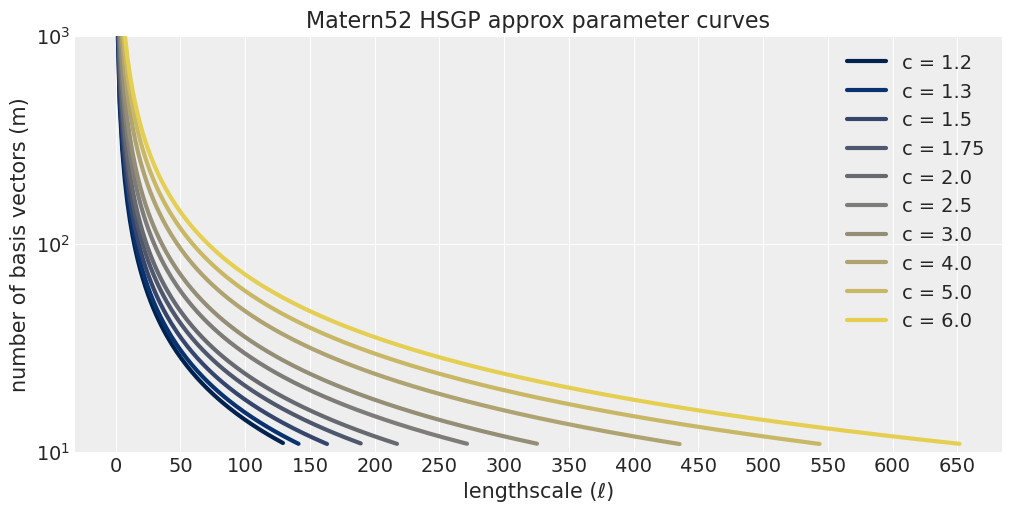

In [71]:
from matplotlib.ticker import MultipleLocator

c_list = np.array([1.2, 1.3, 1.5, 1.75, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0])
ell = np.linspace(1, 1000, 500)
S = (df["year"] - df["year"].mean()).max() # half-range of the input data

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()

cmap = plt.cm.cividis
colors = np.arange(len(c_list)) / len(c_list)

for i, c in enumerate(c_list):
    m = 2.65 * (c / ell) * S
   
    ix = c >= (4.1 * (ell / S))
    m[~ix] = np.nan
    ax.semilogy(ell, m, color=cmap(colors[i]), label="c = %s" % str(c), lw=3);

ax.grid(True);

ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(10))

ax.set_title("Matern52 HSGP approx parameter curves");
ax.set_ylim([10, 1000]);
ax.set_xlabel("lengthscale (ℓ)");
ax.set_ylabel("number of basis vectors (m)");
ax.legend();

The curves show the regions where the HSGP approximation is accurate.  For instance, the darkest blue line at $c=1.2$ means that if we choose $c=1.2$, our approximation will be valid for the smallest lengthscales up until about $\ell = 130$.  The yellow curve at $c=6.0$ means shows that the approximation is accurate up until about $\ell = 650$.  **How we choose these values depends on our prior for the lengthscale**.  In our case we are setting 95% of the prior mass between 20 and 200.  We'll be safe and choose $c=2$ and $m=400$ so our prior range is well covered pretty well.  

Also, keep in mind that HSGP scales as $\mathcal{O}(nm + m)$, so the smaller we can choose $m$, the better, speed-wise.  $c$ plays no role in computation speed.

### Using `HSGP` in PyMC

There are a couple of usage details that are important for using `HSGP` effectively. The first is that, due to how the basis vectors are constructed, the `HSGP` class requires that the `X` input data be centered.  This is because the basis vectors are constructed to be periodic over the range $[-L, L]$, and the center of the range is assumed to be zero.  

So, here we will center the age range on the mean age, taking care to use the closest integer value.

In [72]:
years = df['year'].values
years_centered = years - years[len(years) // 2]

In [73]:
with cherry_blossom_model:

    gp = pm.gp.HSGP(m=[400], c=2.0, cov_func=cov, parametrization='non-centered')
    f = gp.prior("f", X=years_centered[:, None], dims="year")
    
    intercept = pm.Normal("intercept", mu=df["temp"].mean(), sigma=2 * df["temp"].std())
    mu = pm.Deterministic("mu", intercept + f, dims="year")
    
    sigma = pm.HalfNormal("sigma", sigma=2 * df["temp"].std())
    pm.Normal("y", mu=mu, sigma=sigma, observed=df["temp"].values)

Notice that in the specification of `HSGP` the parameterization was set to **non-centered**. This relates to how the power spectrum is entered into the model. Here is what happens under the hood:

First, `prior_linearized` returns the eigenvector basis, `phi`, and the square root of the power spectrum at the eigenvalues, `sqrt_psd`.  You have to construct the HSGP approximation from these.  The following are the relevant lines of code, showing both the centered and non-centered parameterization.

```python
phi, sqrt_psd = gp.prior_linearized(Xs=Xs)

## non-centered
beta = pm.Normal("beta", size=gp._m_star)
f = pm.Deterministic("f", phi @ (beta * sqrt_psd)) 

## centered
beta = pm.Normal("beta", sigma=sqrt_psd, size=gp._m_star)
f = pm.Deterministic("f", phi @ beta) 
```

Choosing a non-centered parameterization may help alleviate sampling issues, but is not always necessary, particularlty if there are plenty of data informing the GP.

In [74]:
with cherry_blossom_model:
    trace_gp = pm.sample(nuts_sampler='nutpie', chains=2)

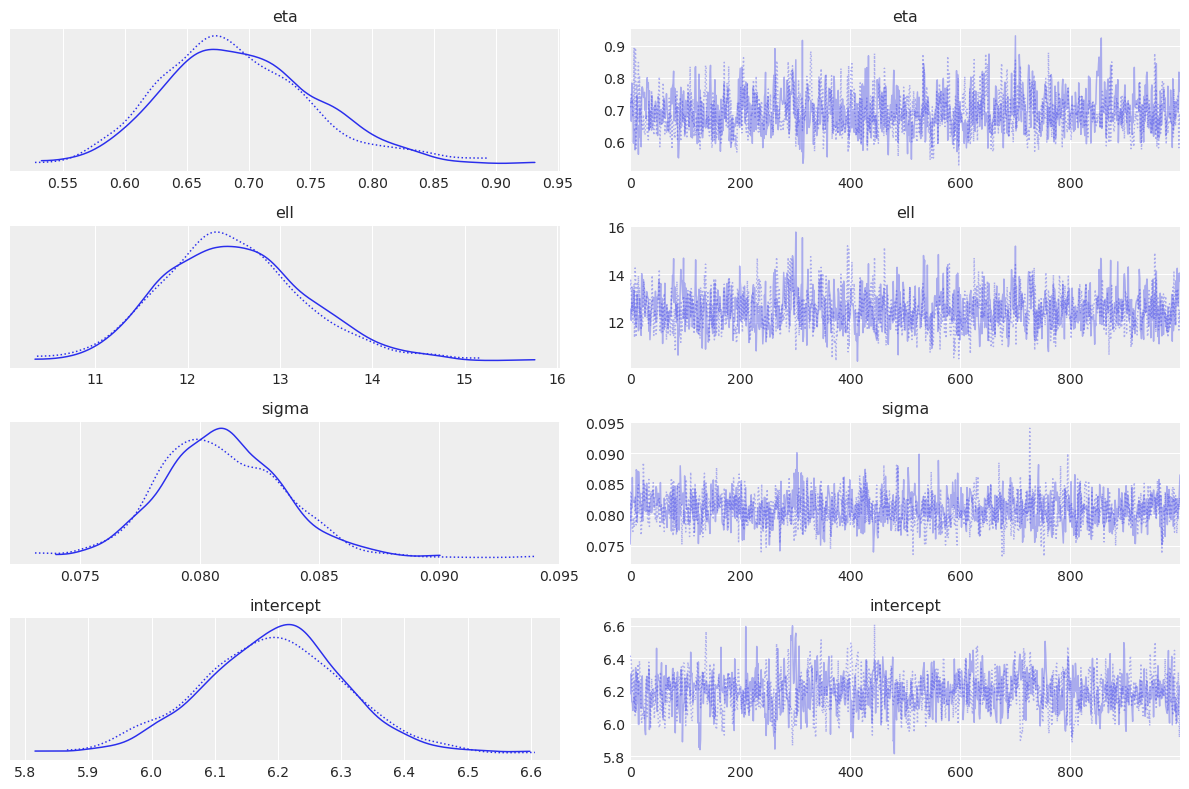

In [75]:
az.plot_trace(trace_gp, var_names=["eta", "ell", "sigma", "intercept"])
plt.tight_layout();

This took a few minutes on my machine. NUTS depends a ton on the posterior geometry, and sampling the GP hyperparameters has a huge influence, but the speeds are still comparable.  We also see a lengthscale of about 40, which we can interpret as meaning that it takes about 40 years for significant changes in temperature to occur.  We can also interpret this to roughly mean that the GP is comfortable predicting out about 40 years.  

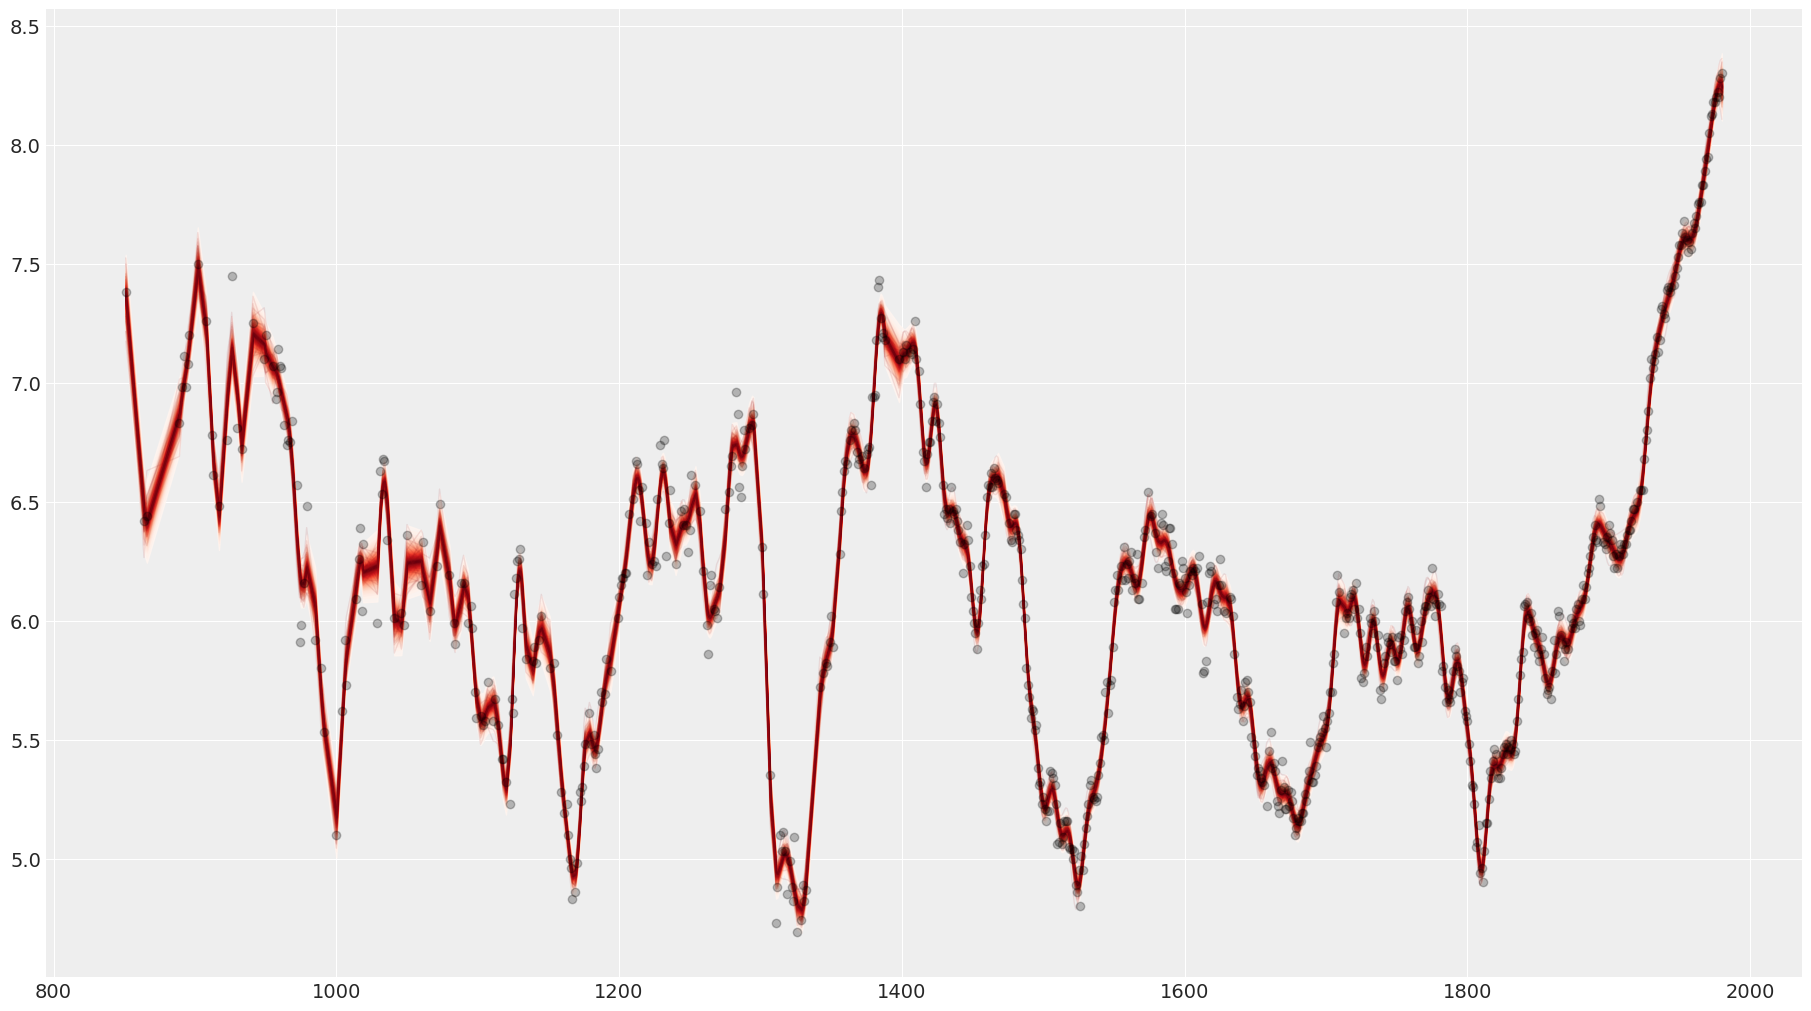

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10));

f = az.extract(trace_gp, group="posterior", var_names="mu")
pm.gp.util.plot_gp_dist(ax=ax, samples=f.values.T, x=df["year"].values)
ax.plot(df["year"].values, df["temp"].values, "ok", alpha=0.25);


The HSGP approximation does carry some restrictions:
1. It **can only be used with _stationary_ covariance kernels** such as the Matern family.  The `HSGP` class is compatible with any `Covariance` class that implements the `power_spectral_density` method.  There is a special case made for the `Periodic` covariance, which is implemented in PyMC by The `HSGPPeriodic`.
2. It **does not scale well with the input dimension**.  The HSGP approximation is a good choice if your GP is over a one dimensional process like a time series, or a two dimensional spatial point process.  It's likely not an efficient choice where the input dimension is larger than three. 
3. It **_may_ struggle with more rapidly varying processes**.  If the process you're trying to model changes very quickly relative to the extent of the domain, the HSGP approximation may fail to accurately represent it.  We'll show in later sections how to set the accuracy of the approximation, which involves a trade-off between the fidelity of the approximation and the computational complexity.

## Looking Forward

While our comprehensive model captures many important patterns, time series modeling is an iterative process. Natural extensions might include **time-varying coefficients** that allow seasonal patterns to evolve over decades as medical practices change. Incorporating **external covariates** such as economic indicators, weather data, or policy changes could explain additional variation. With regional data, **hierarchical modeling** could reveal geographic differences in birth patterns while borrowing strength across locations. For the purist, using **count distributions** for the raw birth numbers rather than a normal approximation would be more principled, though the large daily counts make the normal approximation quite reasonable.

The generative approach we've demonstrated provides a flexible foundation for all these extensions. By building models that reflect our understanding of the data-generating process, we create tools that not only fit the data well but also provide actionable insights. This philosophy—combining domain knowledge with principled statistical methods—represents the best of modern Bayesian time series analysis.

---
## References

[Rasmussen, C. E., & Williams, C. K. I. (2005). Gaussian Processes for Machine Learning (Adaptive Computation and Machine Learning series). The MIT Press.](http://www.amazon.com/books/dp/026218253X)



In [77]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jun 05 2025

Python implementation: CPython
Python version       : 3.13.3
IPython version      : 9.1.0

matplotlib: 3.10.1
arviz     : 0.21.0
pandas    : 2.2.3
seaborn   : 0.13.2
scipy     : 1.15.2
pytensor  : 2.30.3
numpy     : 2.2.5
pymc      : 5.22.0

Watermark: 2.5.0

